In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
seed = 161
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [5]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  STI6WR1Z_03_43_52
NN-MODEL FILENAME:  ./models/STI6WR1Z_03_43_52_NN.pt


In [6]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [7]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [8]:
T_LR           = 1e-1
T_GAMMA        = 0.95
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 200
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 200


In [9]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 100000

In [10]:
MAX_NO_OF_ITERATIONS = 35
MAX_NN_ITERATIONS    = 7000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  35


In [11]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
        bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

        good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [13]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.925
LENGTH_ABS_MIN = 0.375

In [14]:
# SET GRANULARITY
HI_GRAIN = 30
LO_GRAIN = 30
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  30
LO_GRAIN =  30


In [15]:
def mp_node_run(node_id, boundary, iteration):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
    
    # Mean values of pole length deviate by 40% from original value
    scaling_factor = 0.8 + (1.8 - 0.8) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = boundary
    ###############################################

    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN, LENGTH_MAX, LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
                                    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
    
#     my_dqn = D3QN()
#     my_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
#     my_dqn.eval_net.eval()
#     my_Q_TABLE = my_dqn.get_qvals(state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)

    my_QFILE   = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
    my_Q_TABLE = np.load(my_QFILE)

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
    if iteration < 3:
        my_EPSILON   = (iteration+1) * 0.2 + np.random.uniform(-0.1,0.1)
    else:
        my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

                     
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]
    
#     LENGTH_MAX = exp_rec[:,4].max() + 0.25*np.abs(exp_rec[:,4].max())
#     LENGTH_MIN = exp_rec[:,4].min() - 0.25*np.abs(exp_rec[:,4].min())

    # CLAMP STATE VALUE BORDERS
    ###############################################
#     C_POS_MAX = clamp(C_POS_ABS_MIN, C_POS_MAX, C_POS_ABS_MAX)
#     C_POS_MIN = clamp(C_POS_ABS_MIN, C_POS_MIN, C_POS_ABS_MAX) 

#     C_VEL_MAX = clamp(C_VEL_ABS_MIN, C_VEL_MAX, C_VEL_ABS_MAX)
#     C_VEL_MIN = clamp(C_VEL_ABS_MIN, C_VEL_MIN, C_VEL_ABS_MAX) 

#     P_ANG_MAX = clamp(P_ANG_ABS_MIN, P_ANG_MAX, P_ANG_ABS_MAX)
#     P_ANG_MIN = clamp(P_ANG_ABS_MIN, P_ANG_MIN, P_ANG_ABS_MAX) 

#     P_VEL_MAX = clamp(P_VEL_ABS_MIN, P_VEL_MAX, P_VEL_ABS_MAX)
#     P_VEL_MIN = clamp(P_VEL_ABS_MIN, P_VEL_MIN, P_VEL_ABS_MAX) 

#     LENGTH_MAX = clamp(LENGTH_ABS_MIN, LENGTH_MAX, LENGTH_ABS_MAX)
#     LENGTH_MIN = clamp(LENGTH_ABS_MIN, LENGTH_MIN, LENGTH_ABS_MAX)
    ###############################################
    
    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [16]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [17]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()
# INITIALIZE MODEL FILE
# torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

In [18]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# INITIALIZE QFILES FOR EACH NODE
#############################################################################################################################################
# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]

 # SET STATE VALUE BORDERS
###############################################
[C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
 C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = init_node_boundary
###############################################

# CREATE STATE COMBINATIONS
###############################################

init_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
                                    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
###############################################

# GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
for node_id in range(NO_OF_NODES):
    node_QFILE = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
    np.save(node_QFILE, init_q_table)
#############################################################################################################################################

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES

peak memory: 11426.13 MiB, increment: 10346.86 MiB
Quantization TIME:  0.15 minutes




ITERATION # 0
MEAN TABULAR EPSILON =  0.2
TABULAR LR      =  0.1
SMALLEST TIMESTEP in ITERATION 0: 8
REAL TIME TO GENERATE 40714 EXPERIENCES:0:00:07.844163


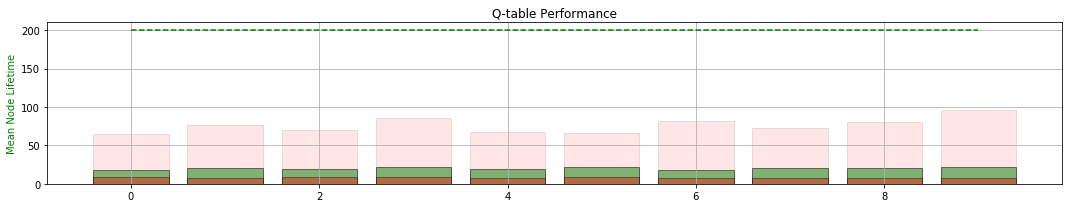

GOOD MEMORY COUNTER:  38714
BAD MEMORY COUNTER:  2000
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  104.2
Validating... MEAN TIME:  167.71
Validating... MEAN TIME:  153.985
Validating... MEAN TIME:  157.28
Validating... MEAN TIME:  156.095
TRAINING TIME:0:00:52.724178


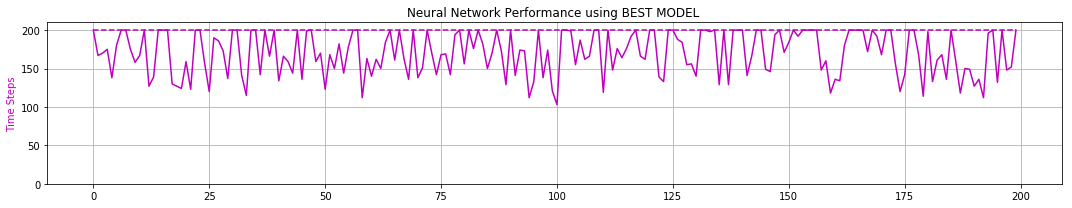

0 -max- [ 0.944  2.313  0.209  1.870  0.475]
0 -min- [-0.563 -1.509 -0.209 -2.961  0.425]

peak memory: 12344.47 MiB, increment: 10196.64 MiB
1 -max- [ 0.701  1.951  0.209  2.432  0.525]
1 -min- [-0.408 -1.587 -0.209 -2.690  0.476]

peak memory: 12415.73 MiB, increment: 10175.14 MiB
2 -max- [ 0.549  2.848  0.209  2.783  0.575]
2 -min- [-0.351 -1.941 -0.209 -3.165  0.525]

peak memory: 12437.52 MiB, increment: 10196.68 MiB
3 -max- [ 0.871  2.607  0.209  2.060  0.624]
3 -min- [-0.211 -1.382 -0.209 -2.723  0.575]

peak memory: 12563.39 MiB, increment: 10322.57 MiB
4 -max- [ 0.710  3.288  0.207  2.108  0.675]
4 -min- [-0.474 -1.480 -0.209 -3.370  0.625]

peak memory: 12592.61 MiB, increment: 10351.79 MiB
5 -max- [ 0.510  2.247  0.209  2.715  0.725]
5 -min- [-0.480 -1.787 -0.209 -2.772  0.675]

peak memory: 12437.14 MiB, increment: 10196.22 MiB
6 -max- [ 0.519  1.987  0.206  1.786  0.775]
6 -min- [-1.021 -1.720 -0.209 -2.837  0.725]

peak memory: 12464.01 MiB, increment: 10223.11 MiB
7 -max

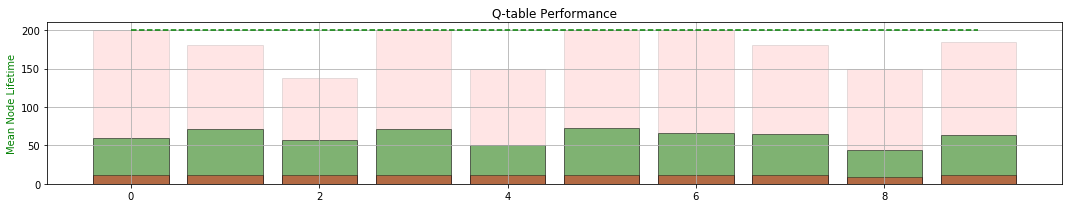

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  3996
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  171.465
Validating... MEAN TIME:  181.325
Validating... MEAN TIME:  182.55
Validating... MEAN TIME:  161.08
Validating... MEAN TIME:  192.315
TRAINING TIME:0:01:00.973774


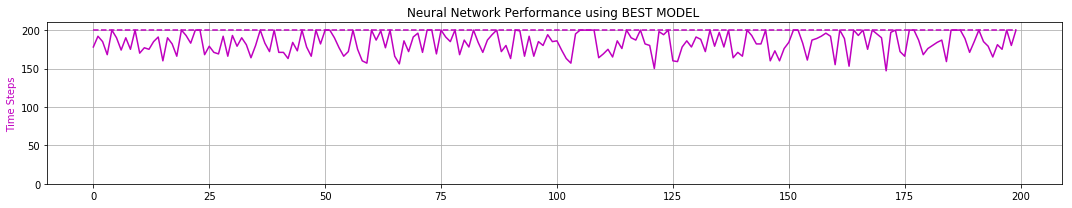

0 -max- [ 2.333  2.634  0.209  2.142  0.475]
0 -min- [-1.240 -2.268 -0.209 -2.359  0.425]

peak memory: 12630.82 MiB, increment: 10350.25 MiB
1 -max- [ 2.011  2.230  0.209  2.383  0.525]
1 -min- [-1.539 -2.657 -0.209 -2.116  0.475]

peak memory: 12466.72 MiB, increment: 10186.16 MiB
2 -max- [ 1.858  2.220  0.209  2.382  0.575]
2 -min- [-1.228 -2.283 -0.209 -2.141  0.525]

peak memory: 12530.14 MiB, increment: 10249.59 MiB
3 -max- [ 1.685  2.081  0.209  2.037  0.624]
3 -min- [-1.482 -2.375 -0.209 -2.414  0.575]

peak memory: 12477.04 MiB, increment: 10196.48 MiB
4 -max- [ 1.622  2.303  0.209  2.511  0.675]
4 -min- [-1.161 -2.499 -0.209 -2.572  0.625]

peak memory: 12501.26 MiB, increment: 10220.71 MiB
5 -max- [ 1.654  2.064  0.209  2.657  0.725]
5 -min- [-1.444 -2.480 -0.209 -2.343  0.675]

peak memory: 12469.85 MiB, increment: 10189.04 MiB
6 -max- [ 0.652  2.098  0.208  2.334  0.775]
6 -min- [-1.399 -2.388 -0.209 -2.433  0.726]

peak memory: 12434.53 MiB, increment: 10153.72 MiB
7 -max

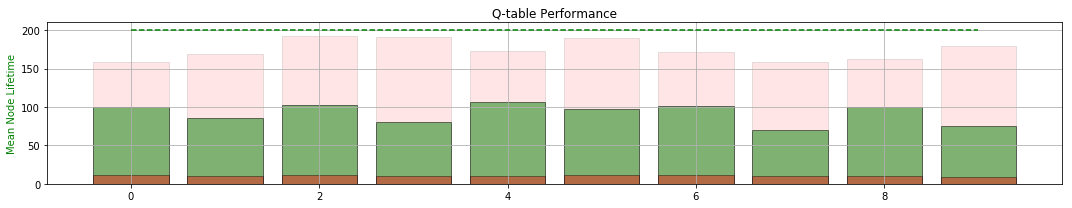

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  5996
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  135.785
Validating... MEAN TIME:  144.21
Validating... MEAN TIME:  127.5
Validating... MEAN TIME:  139.97
Validating... MEAN TIME:  137.11
TRAINING TIME:0:00:49.346270


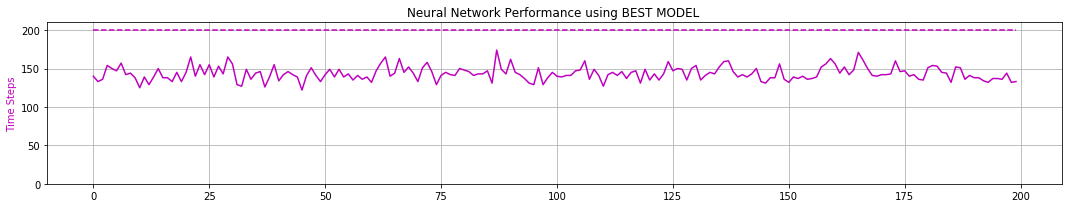

0 -max- [ 0.190  1.375  0.208  2.301  0.475]
0 -min- [-2.399 -3.116 -0.209 -2.021  0.426]

peak memory: 12574.42 MiB, increment: 10250.92 MiB
1 -max- [ 0.246  1.407  0.202  1.776  0.525]
1 -min- [-2.399 -3.116 -0.209 -2.168  0.476]

peak memory: 12679.23 MiB, increment: 10355.74 MiB
2 -max- [ 0.281  1.180  0.208  2.243  0.575]
2 -min- [-2.400 -3.170 -0.209 -1.984  0.525]

peak memory: 12605.12 MiB, increment: 10281.63 MiB
3 -max- [ 0.548  1.878  0.204  2.129  0.625]
3 -min- [-2.400 -3.138 -0.209 -2.126  0.575]

peak memory: 12527.41 MiB, increment: 10204.18 MiB
4 -max- [ 0.189  1.203  0.175  1.874  0.675]
4 -min- [-2.400 -3.121 -0.209 -1.835  0.625]

peak memory: 12607.66 MiB, increment: 10284.17 MiB
5 -max- [ 0.388  1.416  0.209  1.763  0.725]
5 -min- [-2.399 -3.104 -0.209 -2.268  0.675]

peak memory: 12479.17 MiB, increment: 10155.68 MiB
6 -max- [ 0.283  1.403  0.209  2.004  0.775]
6 -min- [-2.399 -2.973 -0.209 -2.135  0.725]

peak memory: 12464.50 MiB, increment: 10141.02 MiB
7 -max

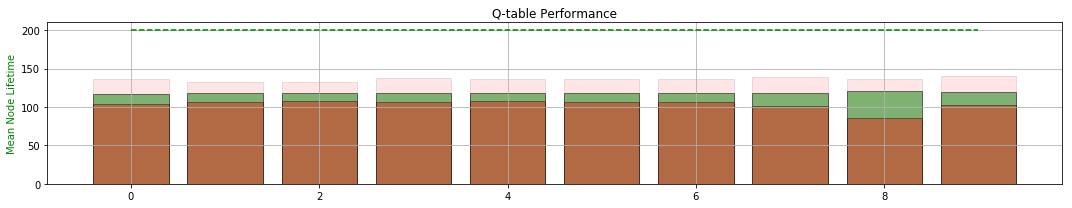

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  7996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  120.64
Validating... MEAN TIME:  129.05
Validating... MEAN TIME:  123.745
Validating... MEAN TIME:  131.0
Validating... MEAN TIME:  122.98
TRAINING TIME:0:00:46.434376


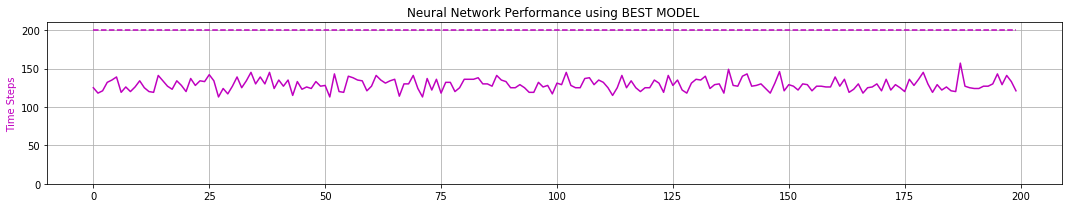

0 -max- [ 0.166  0.824  0.053  0.871  0.475]
0 -min- [-2.400 -2.917 -0.192 -1.217  0.425]

peak memory: 12563.82 MiB, increment: 10180.43 MiB
1 -max- [ 0.137  0.807  0.049  1.113  0.524]
1 -min- [-2.400 -2.952 -0.186 -1.217  0.475]

peak memory: 12672.75 MiB, increment: 10289.37 MiB
2 -max- [ 0.133  0.817  0.049  0.862  0.575]
2 -min- [-2.400 -2.964 -0.187 -1.154  0.525]

peak memory: 12539.86 MiB, increment: 10156.49 MiB
3 -max- [ 0.140  0.824  0.050  0.856  0.625]
3 -min- [-2.400 -2.797 -0.198 -1.210  0.575]

peak memory: 12544.71 MiB, increment: 10161.34 MiB
4 -max- [ 0.137  0.826  0.050  0.924  0.675]
4 -min- [-2.400 -2.796 -0.201 -1.182  0.625]

peak memory: 12749.79 MiB, increment: 10366.43 MiB
5 -max- [ 0.149  1.001  0.049  1.142  0.725]
5 -min- [-2.400 -2.904 -0.198 -1.478  0.675]

peak memory: 12579.89 MiB, increment: 10196.54 MiB
6 -max- [ 0.153  0.980  0.049  0.839  0.775]
6 -min- [-2.400 -2.950 -0.206 -1.397  0.725]

peak memory: 12580.04 MiB, increment: 10196.69 MiB
7 -max

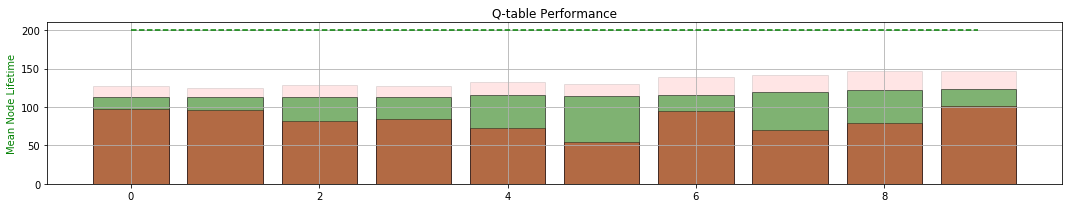

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  9996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  117.905
Validating... MEAN TIME:  116.69
Validating... MEAN TIME:  117.29
Validating... MEAN TIME:  115.665
Validating... MEAN TIME:  117.09
TRAINING TIME:0:00:43.847460


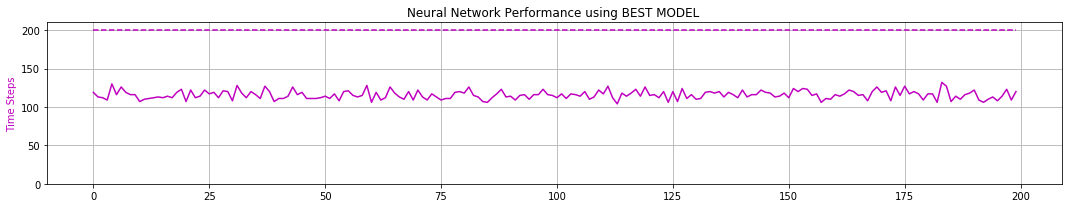

0 -max- [ 0.137  0.807  0.049  0.785  0.475]
0 -min- [-2.400 -3.142 -0.209 -1.192  0.425]

peak memory: 12574.96 MiB, increment: 10196.61 MiB
1 -max- [ 0.138  0.827  0.049  0.820  0.525]
1 -min- [-2.400 -3.100 -0.208 -1.185  0.475]

peak memory: 12544.59 MiB, increment: 10166.25 MiB
2 -max- [ 0.140  0.824  0.050  0.666  0.575]
2 -min- [-2.400 -3.083 -0.208 -1.155  0.525]

peak memory: 12579.41 MiB, increment: 10201.07 MiB
3 -max- [ 0.123  0.826  0.050  0.791  0.625]
3 -min- [-2.400 -3.148 -0.208 -1.177  0.575]

peak memory: 12574.98 MiB, increment: 10196.64 MiB
4 -max- [ 0.127  0.824  0.049  0.726  0.675]
4 -min- [-2.400 -3.086 -0.209 -1.193  0.625]

peak memory: 12574.62 MiB, increment: 10196.55 MiB
5 -max- [ 0.128  0.825  0.057  0.859  0.725]
5 -min- [-2.399 -3.100 -0.209 -1.128  0.675]

peak memory: 12537.25 MiB, increment: 10159.19 MiB
6 -max- [ 0.131  0.766  0.050  0.842  0.775]
6 -min- [-2.400 -3.117 -0.209 -1.211  0.725]

peak memory: 12566.47 MiB, increment: 10187.89 MiB
7 -max

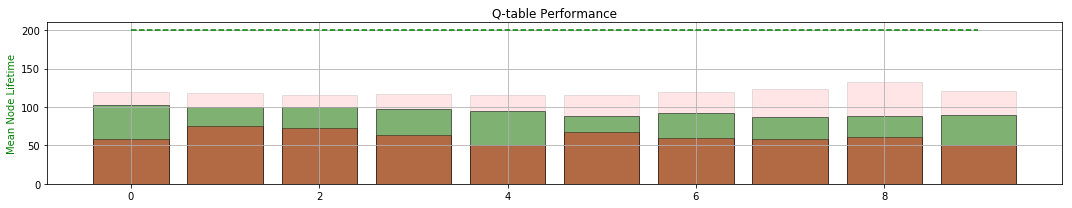

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  11996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  115.815
Validating... MEAN TIME:  106.065
Validating... MEAN TIME:  106.515
Validating... MEAN TIME:  105.13
Validating... MEAN TIME:  112.515
TRAINING TIME:0:00:41.786073


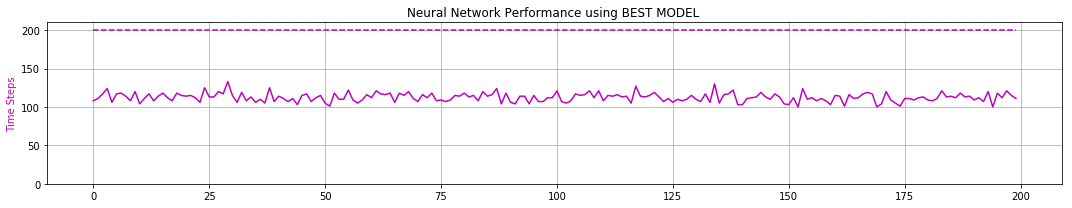

0 -max- [ 0.156  0.939  0.049  0.818  0.475]
0 -min- [-2.400 -3.330 -0.209 -1.442  0.425]

peak memory: 12600.78 MiB, increment: 10196.43 MiB
1 -max- [ 0.151  0.824  0.050  0.659  0.525]
1 -min- [-2.399 -3.345 -0.209 -1.225  0.475]

peak memory: 12599.64 MiB, increment: 10195.30 MiB
2 -max- [ 0.138  0.827  0.050  0.699  0.575]
2 -min- [-2.400 -3.323 -0.209 -1.183  0.525]

peak memory: 12601.01 MiB, increment: 10196.67 MiB
3 -max- [ 0.147  0.824  0.049  0.796  0.625]
3 -min- [-2.400 -3.301 -0.209 -1.317  0.575]

peak memory: 12601.35 MiB, increment: 10196.50 MiB
4 -max- [ 0.145  0.825  0.049  0.837  0.675]
4 -min- [-2.399 -3.320 -0.209 -1.218  0.625]

peak memory: 12601.48 MiB, increment: 10196.63 MiB
5 -max- [ 0.144  0.927  0.050  0.662  0.725]
5 -min- [-2.400 -3.305 -0.209 -1.380  0.675]

peak memory: 12590.19 MiB, increment: 10185.34 MiB
6 -max- [ 0.136  1.023  0.053  0.675  0.775]
6 -min- [-2.398 -3.296 -0.209 -1.487  0.725]

peak memory: 12736.74 MiB, increment: 10331.90 MiB
7 -max

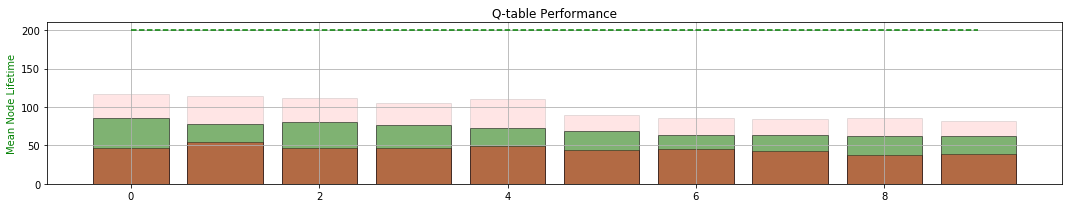

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  13996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  102.92
Validating... MEAN TIME:  108.75
Validating... MEAN TIME:  107.74
Validating... MEAN TIME:  104.445
Validating... MEAN TIME:  110.155
TRAINING TIME:0:00:41.132942


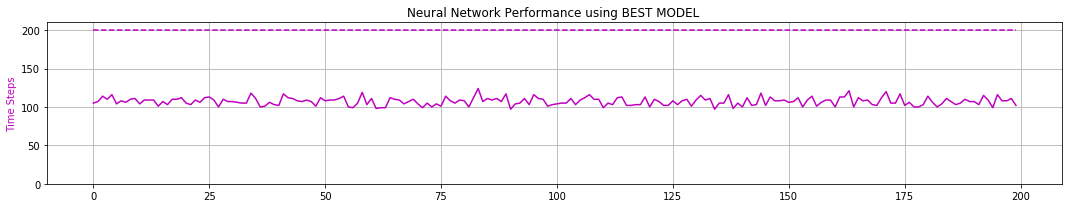

0 -max- [ 0.140  0.824  0.050  0.668  0.475]
0 -min- [-2.397 -3.310 -0.209 -1.200  0.425]

peak memory: 12584.32 MiB, increment: 10172.88 MiB
1 -max- [ 0.126  0.829  0.050  0.680  0.525]
1 -min- [-2.398 -3.327 -0.209 -1.214  0.475]

peak memory: 12601.50 MiB, increment: 10189.80 MiB
2 -max- [ 0.137  0.999  0.049  0.661  0.574]
2 -min- [-2.400 -3.305 -0.209 -1.437  0.525]

peak memory: 12590.26 MiB, increment: 10178.57 MiB
3 -max- [ 0.145  0.958  0.049  0.855  0.625]
3 -min- [-2.400 -3.305 -0.209 -1.391  0.575]

peak memory: 12608.25 MiB, increment: 10196.56 MiB
4 -max- [ 0.153  0.821  0.050  0.636  0.674]
4 -min- [-2.364 -3.069 -0.209 -1.182  0.625]

peak memory: 12696.43 MiB, increment: 10284.75 MiB
5 -max- [ 0.142  0.956  0.053  0.716  0.725]
5 -min- [-1.353 -2.400 -0.209 -1.393  0.675]

peak memory: 12595.83 MiB, increment: 10184.16 MiB
6 -max- [ 0.165  1.196  0.056  0.912  0.775]
6 -min- [-1.218 -2.191 -0.209 -1.594  0.725]

peak memory: 12582.52 MiB, increment: 10170.86 MiB
7 -max

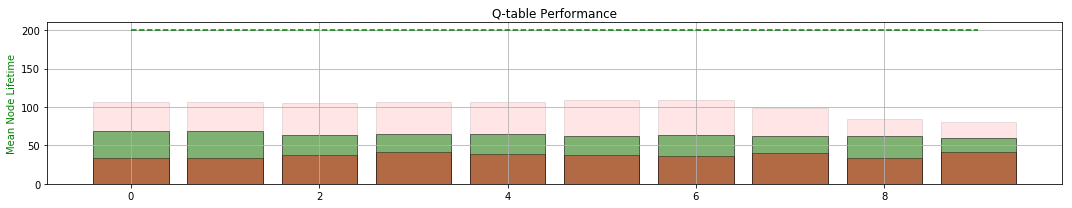

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  15996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  104.875
Validating... MEAN TIME:  103.275
Validating... MEAN TIME:  102.89
Validating... MEAN TIME:  102.905
Validating... MEAN TIME:  107.255
TRAINING TIME:0:00:40.784345


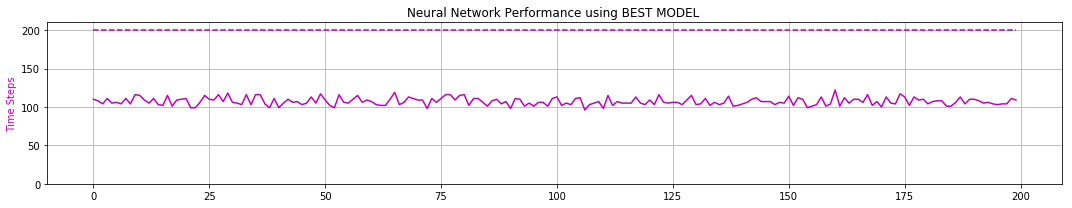

0 -max- [ 0.165  0.994  0.050  0.666  0.474]
0 -min- [-2.400 -3.430 -0.209 -1.396  0.425]

peak memory: 12602.72 MiB, increment: 10191.05 MiB
1 -max- [ 0.157  0.984  0.049  0.662  0.525]
1 -min- [-2.398 -3.449 -0.209 -1.475  0.475]

peak memory: 12675.61 MiB, increment: 10263.94 MiB
2 -max- [ 0.161  0.827  0.049  0.649  0.575]
2 -min- [-2.382 -3.335 -0.209 -1.236  0.525]

peak memory: 12605.92 MiB, increment: 10194.26 MiB
3 -max- [ 0.166  1.013  0.053  0.642  0.625]
3 -min- [-2.398 -3.340 -0.209 -1.467  0.575]

peak memory: 12642.40 MiB, increment: 10230.75 MiB
4 -max- [ 0.165  1.126  0.050  0.684  0.675]
4 -min- [-2.398 -3.304 -0.209 -1.707  0.625]

peak memory: 12604.28 MiB, increment: 10192.63 MiB
5 -max- [ 0.167  0.966  0.050  0.686  0.724]
5 -min- [-2.392 -3.276 -0.209 -1.413  0.675]

peak memory: 12599.33 MiB, increment: 10187.69 MiB
6 -max- [ 0.158  0.827  0.049  0.711  0.775]
6 -min- [-2.381 -3.105 -0.209 -1.242  0.726]

peak memory: 12729.28 MiB, increment: 10317.65 MiB
7 -max

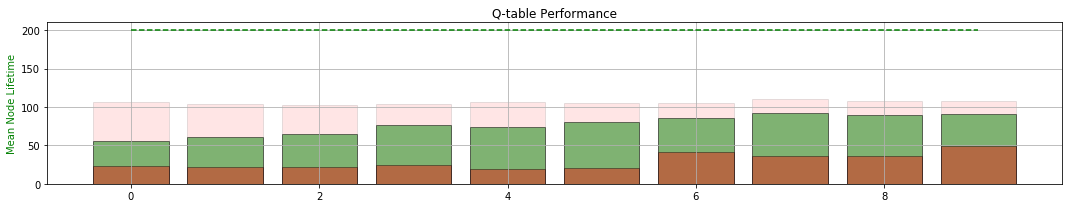

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  17996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  100.07
Validating... MEAN TIME:  99.39
Validating... MEAN TIME:  98.24
Validating... MEAN TIME:  102.235
Validating... MEAN TIME:  100.13
TRAINING TIME:0:00:39.271119


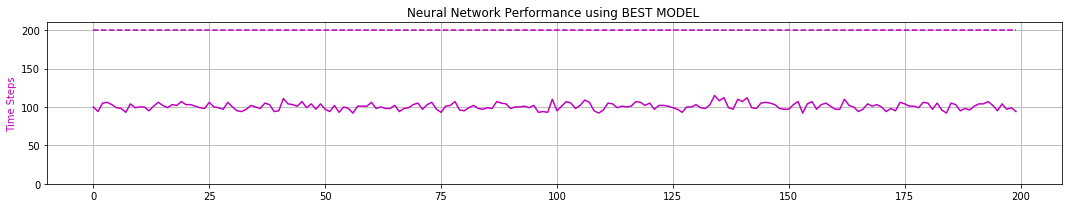

0 -max- [ 0.168  0.831  0.049  0.690  0.475]
0 -min- [-2.400 -3.138 -0.209 -1.247  0.425]

peak memory: 12532.55 MiB, increment: 10174.80 MiB
1 -max- [ 0.169  0.985  0.050  0.690  0.525]
1 -min- [-2.399 -3.151 -0.209 -1.421  0.475]

peak memory: 12520.38 MiB, increment: 10162.64 MiB
2 -max- [ 0.179  0.985  0.050  0.660  0.575]
2 -min- [-2.400 -3.161 -0.209 -1.551  0.525]

peak memory: 12570.41 MiB, increment: 10212.68 MiB
3 -max- [ 0.166  0.931  0.050  0.698  0.625]
3 -min- [-2.400 -3.274 -0.209 -1.380  0.575]

peak memory: 12551.11 MiB, increment: 10193.39 MiB
4 -max- [ 0.189  0.997  0.050  0.779  0.675]
4 -min- [-2.400 -3.154 -0.209 -1.516  0.626]

peak memory: 12716.59 MiB, increment: 10358.86 MiB
5 -max- [ 0.178  0.944  0.049  0.755  0.724]
5 -min- [-2.400 -3.329 -0.209 -1.444  0.676]

peak memory: 12554.37 MiB, increment: 10196.66 MiB
6 -max- [ 0.169  0.954  0.049  0.672  0.774]
6 -min- [-2.400 -3.147 -0.209 -1.388  0.725]

peak memory: 12577.68 MiB, increment: 10219.98 MiB
7 -max

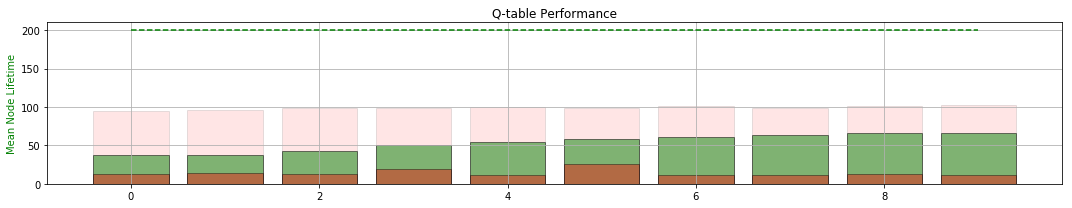

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  19996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  100.87
Validating... MEAN TIME:  98.005
Validating... MEAN TIME:  96.52
Validating... MEAN TIME:  95.34
Validating... MEAN TIME:  98.245
TRAINING TIME:0:00:38.381195


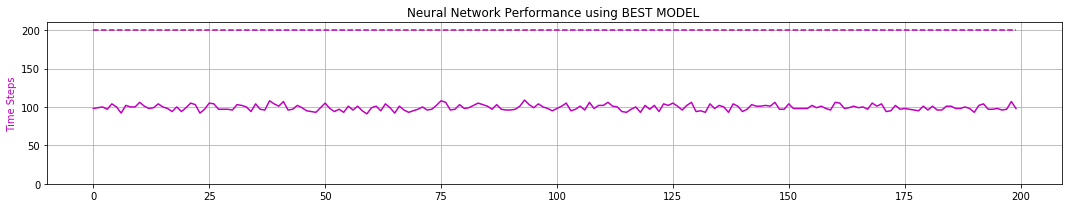

0 -max- [ 0.181  1.216  0.062  0.644  0.475]
0 -min- [-2.388 -3.309 -0.209 -1.748  0.426]

peak memory: 12624.33 MiB, increment: 10256.91 MiB
1 -max- [ 0.185  1.211  0.050  0.641  0.525]
1 -min- [-2.395 -3.329 -0.209 -1.736  0.476]

peak memory: 12673.93 MiB, increment: 10306.51 MiB
2 -max- [ 0.212  1.216  0.050  0.580  0.574]
2 -min- [-2.394 -3.492 -0.209 -1.746  0.525]

peak memory: 12563.95 MiB, increment: 10196.54 MiB
3 -max- [ 0.212  1.216  0.050  0.659  0.625]
3 -min- [-2.399 -3.311 -0.209 -1.746  0.576]

peak memory: 12563.95 MiB, increment: 10196.54 MiB
4 -max- [ 0.205  1.335  0.049  0.663  0.675]
4 -min- [-2.400 -3.320 -0.209 -2.046  0.625]

peak memory: 12510.03 MiB, increment: 10142.62 MiB
5 -max- [ 0.192  1.210  0.049  0.615  0.725]
5 -min- [-2.400 -3.333 -0.209 -1.735  0.675]

peak memory: 12564.16 MiB, increment: 10196.50 MiB
6 -max- [ 0.200  1.402  0.050  0.659  0.775]
6 -min- [-2.398 -3.332 -0.209 -1.970  0.725]

peak memory: 12521.69 MiB, increment: 10154.04 MiB
7 -max

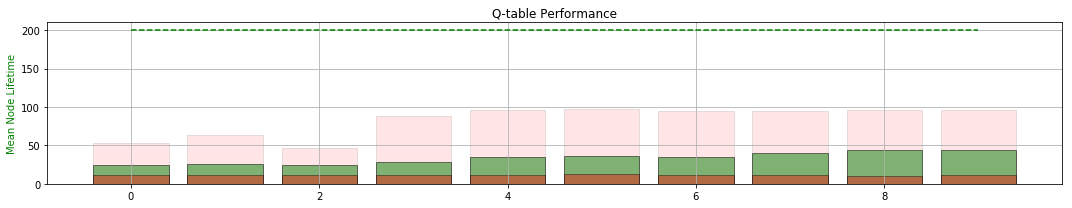

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  21996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  95.265
Validating... MEAN TIME:  96.285
Validating... MEAN TIME:  95.3
Validating... MEAN TIME:  96.435
Validating... MEAN TIME:  95.475
TRAINING TIME:0:00:38.562498


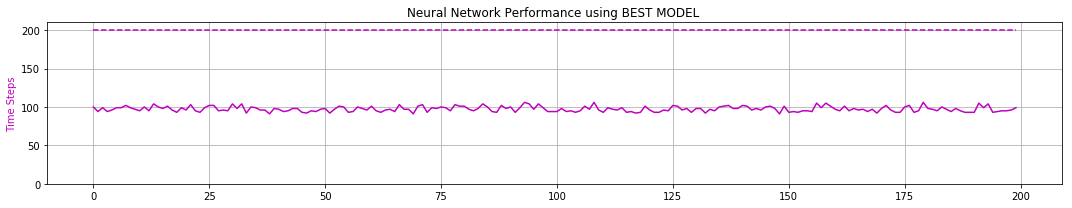

0 -max- [ 0.187  1.211  0.050  0.438  0.475]
0 -min- [-0.433 -1.658 -0.209 -1.736  0.426]

peak memory: 12564.14 MiB, increment: 10196.69 MiB
1 -max- [ 0.200  1.216  0.050  0.470  0.525]
1 -min- [-0.743 -2.003 -0.209 -1.746  0.475]

peak memory: 12563.97 MiB, increment: 10196.53 MiB
2 -max- [ 0.206  1.343  0.050  0.610  0.574]
2 -min- [-0.177 -1.274 -0.209 -2.038  0.525]

peak memory: 12600.35 MiB, increment: 10232.91 MiB
3 -max- [ 0.202  1.217  0.049  0.477  0.625]
3 -min- [-2.378 -3.255 -0.209 -1.742  0.575]

peak memory: 12558.16 MiB, increment: 10190.73 MiB
4 -max- [ 0.193  1.210  0.049  0.652  0.675]
4 -min- [-2.390 -3.302 -0.209 -1.735  0.625]

peak memory: 12552.14 MiB, increment: 10184.72 MiB
5 -max- [ 0.200  1.207  0.050  0.665  0.725]
5 -min- [-2.392 -3.467 -0.209 -1.748  0.675]

peak memory: 12566.72 MiB, increment: 10199.30 MiB
6 -max- [ 0.190  1.203  0.054  0.642  0.775]
6 -min- [-2.399 -3.465 -0.209 -1.742  0.725]

peak memory: 12708.18 MiB, increment: 10340.77 MiB
7 -max

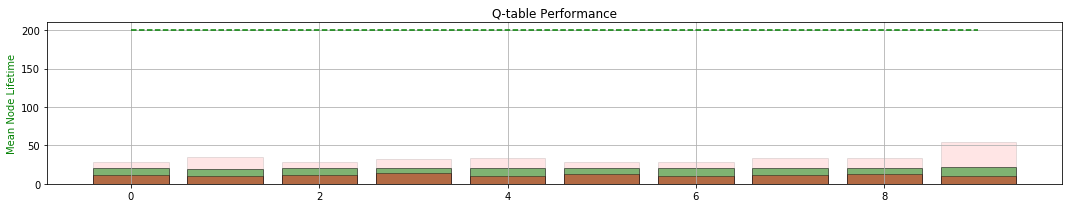

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  23996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  94.965
Validating... MEAN TIME:  96.96
Validating... MEAN TIME:  95.875
Validating... MEAN TIME:  95.45
Validating... MEAN TIME:  94.46
TRAINING TIME:0:00:38.227984


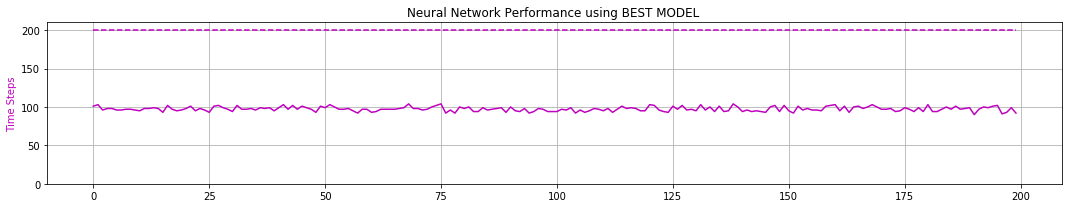

0 -max- [ 0.192  1.215  0.050  0.317  0.475]
0 -min- [-0.049 -0.762 -0.209 -1.721  0.425]

peak memory: 12563.89 MiB, increment: 10196.49 MiB
1 -max- [ 0.206  1.211  0.050  0.373  0.525]
1 -min- [-0.050 -0.902 -0.209 -1.746  0.475]

peak memory: 12564.02 MiB, increment: 10196.62 MiB
2 -max- [ 0.202  1.203  0.049  0.258  0.575]
2 -min- [-0.051 -0.768 -0.209 -1.679  0.525]

peak memory: 12531.54 MiB, increment: 10164.15 MiB
3 -max- [ 0.187  1.172  0.049  0.417  0.624]
3 -min- [-0.059 -0.945 -0.209 -1.661  0.575]

peak memory: 12564.02 MiB, increment: 10196.64 MiB
4 -max- [ 0.200  1.204  0.050  0.409  0.675]
4 -min- [-0.053 -0.946 -0.209 -1.698  0.626]

peak memory: 12510.94 MiB, increment: 10143.57 MiB
5 -max- [ 0.190  1.397  0.050  0.303  0.725]
5 -min- [-0.050 -0.774 -0.209 -1.964  0.675]

peak memory: 12561.04 MiB, increment: 10193.68 MiB
6 -max- [ 0.201  1.363  0.054  0.314  0.775]
6 -min- [-0.050 -0.769 -0.209 -1.958  0.725]

peak memory: 12558.62 MiB, increment: 10191.00 MiB
7 -max

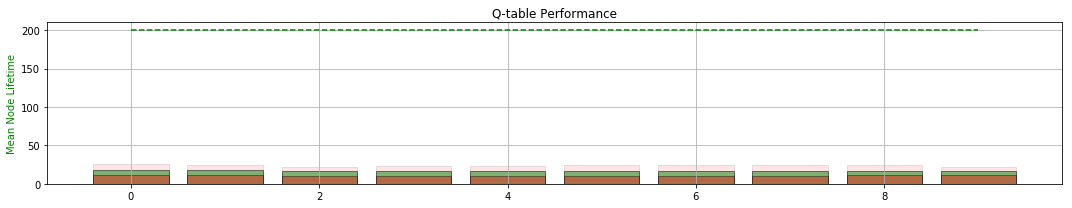

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  25996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  94.17
Validating... MEAN TIME:  95.46
Validating... MEAN TIME:  93.54
Validating... MEAN TIME:  93.46
Validating... MEAN TIME:  91.98
TRAINING TIME:0:00:37.973069


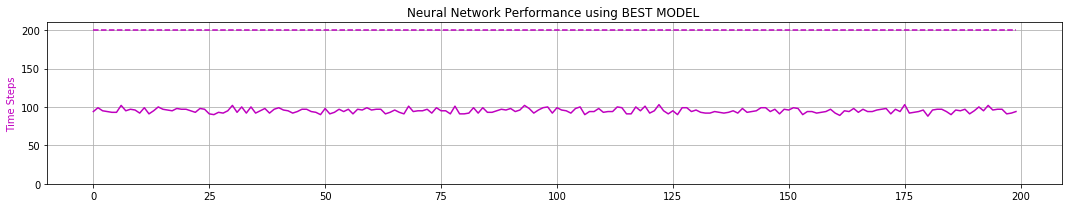

0 -max- [ 0.206  1.211  0.054  0.323  0.475]
0 -min- [-0.050 -0.585 -0.209 -1.705  0.425]

peak memory: 12564.16 MiB, increment: 10196.48 MiB
1 -max- [ 0.206  1.217  0.049  0.301  0.525]
1 -min- [-0.051 -0.413 -0.209 -1.742  0.476]

peak memory: 12664.44 MiB, increment: 10297.02 MiB
2 -max- [ 0.201  1.342  0.049  0.296  0.575]
2 -min- [-0.049 -0.534 -0.209 -1.986  0.525]

peak memory: 12564.08 MiB, increment: 10196.66 MiB
3 -max- [ 0.216  1.207  0.053  0.329  0.625]
3 -min- [-0.049 -0.410 -0.209 -1.758  0.575]

peak memory: 12726.96 MiB, increment: 10359.55 MiB
4 -max- [ 0.205  1.203  0.050  0.234  0.675]
4 -min- [-0.050 -0.582 -0.209 -1.742  0.625]

peak memory: 12564.04 MiB, increment: 10196.64 MiB
5 -max- [ 0.203  1.214  0.050  0.320  0.725]
5 -min- [-0.050 -0.415 -0.209 -1.746  0.675]

peak memory: 12550.32 MiB, increment: 10182.68 MiB
6 -max- [ 0.217  1.218  0.050  0.246  0.775]
6 -min- [-0.050 -0.410 -0.209 -1.745  0.725]

peak memory: 12524.40 MiB, increment: 10156.75 MiB
7 -max

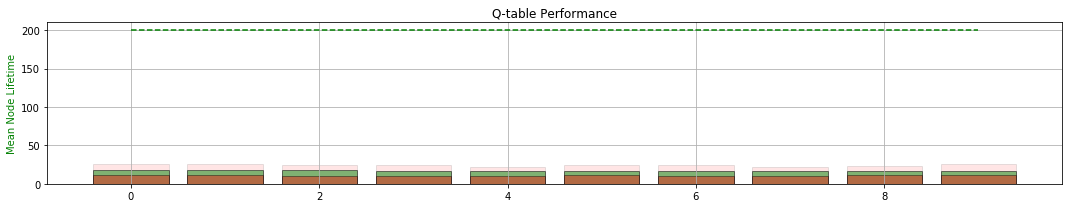

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  27996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  91.555
Validating... MEAN TIME:  73.02
Validating... MEAN TIME:  64.58
Validating... MEAN TIME:  44.3
Validating... MEAN TIME:  33.89
TRAINING TIME:0:00:29.019039


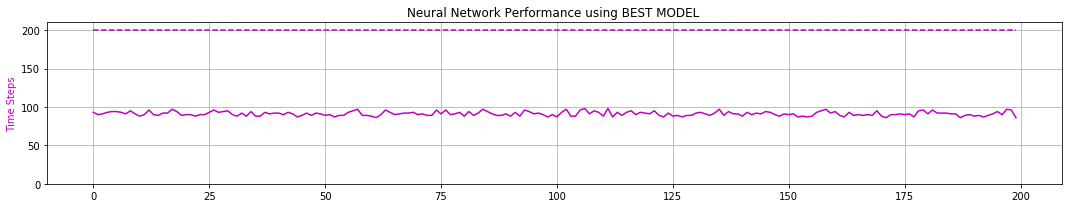

0 -max- [ 0.213  1.022  0.054  0.324  0.474]
0 -min- [-0.051 -0.549 -0.209 -1.564  0.425]

peak memory: 12635.83 MiB, increment: 10268.11 MiB
1 -max- [ 0.196  1.015  0.049  0.328  0.525]
1 -min- [-0.049 -0.415 -0.209 -1.522  0.475]

peak memory: 12558.61 MiB, increment: 10191.16 MiB
2 -max- [ 0.216  1.193  0.050  0.311  0.575]
2 -min- [-0.049 -0.411 -0.209 -1.718  0.525]

peak memory: 12564.25 MiB, increment: 10196.80 MiB
3 -max- [ 0.211  1.025  0.050  0.298  0.625]
3 -min- [-0.050 -0.410 -0.209 -1.597  0.575]

peak memory: 12545.64 MiB, increment: 10178.20 MiB
4 -max- [ 0.203  1.025  0.050  0.333  0.675]
4 -min- [-0.050 -0.415 -0.209 -1.607  0.626]

peak memory: 12564.20 MiB, increment: 10196.50 MiB
5 -max- [ 0.217  1.135  0.050  0.279  0.725]
5 -min- [-0.050 -0.414 -0.209 -1.780  0.675]

peak memory: 12564.31 MiB, increment: 10196.62 MiB
6 -max- [ 0.194  1.183  0.049  0.236  0.775]
6 -min- [-0.050 -0.405 -0.209 -1.699  0.725]

peak memory: 12573.26 MiB, increment: 10205.57 MiB
7 -max

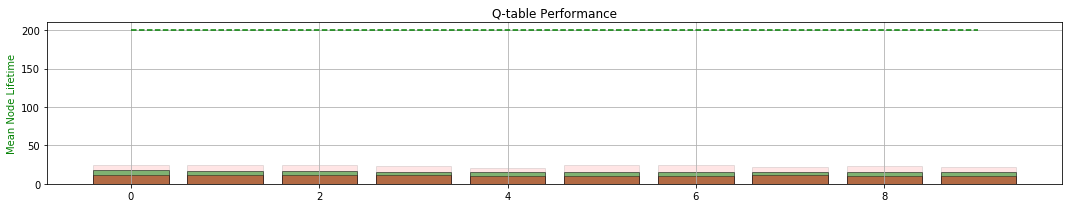

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  29996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  27.98
Validating... MEAN TIME:  24.195
Validating... MEAN TIME:  24.325
Validating... MEAN TIME:  25.675
Validating... MEAN TIME:  23.98
TRAINING TIME:0:00:19.844534


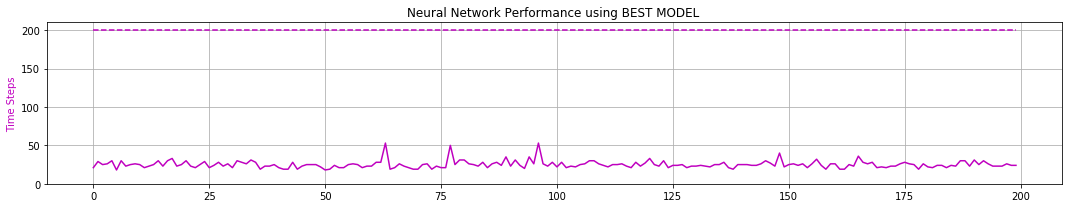

0 -max- [ 0.196  1.015  0.049  0.268  0.475]
0 -min- [-0.049 -0.412 -0.209 -1.488  0.425]

peak memory: 12549.24 MiB, increment: 10181.86 MiB
1 -max- [ 0.216  1.317  0.050  0.270  0.525]
1 -min- [-0.049 -0.410 -0.209 -2.000  0.475]

peak memory: 12564.25 MiB, increment: 10196.88 MiB
2 -max- [ 0.210  1.008  0.050  0.353  0.575]
2 -min- [-0.050 -0.538 -0.209 -1.604  0.525]

peak memory: 12556.25 MiB, increment: 10188.89 MiB
3 -max- [ 0.203  1.019  0.050  0.185  0.624]
3 -min- [-0.050 -0.418 -0.209 -1.562  0.575]

peak memory: 12531.14 MiB, increment: 10163.53 MiB
4 -max- [ 0.217  1.023  0.050  0.263  0.675]
4 -min- [-0.050 -0.419 -0.209 -1.630  0.625]

peak memory: 12746.04 MiB, increment: 10378.43 MiB
5 -max- [ 0.198  1.024  0.049  0.335  0.725]
5 -min- [-0.050 -0.415 -0.209 -1.579  0.676]

peak memory: 12533.05 MiB, increment: 10165.44 MiB
6 -max- [ 0.208  1.214  0.050  0.356  0.775]
6 -min- [-0.050 -0.600 -0.209 -1.752  0.725]

peak memory: 12550.08 MiB, increment: 10182.48 MiB
7 -max

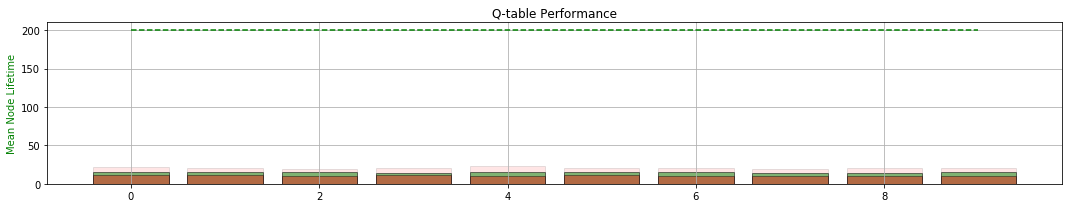

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  31996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  28.635
Validating... MEAN TIME:  47.165
Validating... MEAN TIME:  43.16
Validating... MEAN TIME:  42.27
Validating... MEAN TIME:  43.665
TRAINING TIME:0:00:23.820873


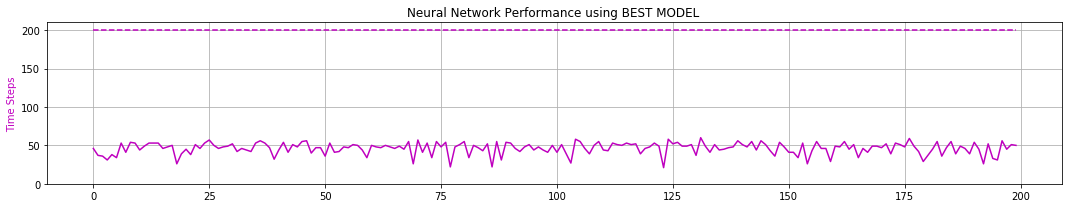

0 -max- [ 0.224  1.011  0.050  0.050  0.475]
0 -min- [-0.049 -0.392 -0.209 -1.588  0.425]

peak memory: 12557.92 MiB, increment: 10190.45 MiB
1 -max- [ 0.211  1.009  0.050  0.097  0.525]
1 -min- [-0.050 -0.416 -0.209 -1.565  0.475]

peak memory: 12522.77 MiB, increment: 10155.29 MiB
2 -max- [ 0.206  1.185  0.050  0.049  0.575]
2 -min- [-0.050 -0.226 -0.209 -1.712  0.525]

peak memory: 12528.57 MiB, increment: 10161.11 MiB
3 -max- [ 0.217  1.023  0.052  0.271  0.625]
3 -min- [-0.050 -0.349 -0.209 -1.514  0.575]

peak memory: 12673.97 MiB, increment: 10306.51 MiB
4 -max- [ 0.200  1.025  0.054  0.319  0.674]
4 -min- [-0.050 -0.228 -0.209 -1.599  0.625]

peak memory: 12558.67 MiB, increment: 10190.95 MiB
5 -max- [ 0.209  1.192  0.050  0.334  0.725]
5 -min- [-0.050 -0.233 -0.209 -1.707  0.675]

peak memory: 12563.25 MiB, increment: 10195.53 MiB
6 -max- [ 0.220  1.132  0.049  0.284  0.774]
6 -min- [-0.052 -0.231 -0.209 -1.729  0.725]

peak memory: 12553.79 MiB, increment: 10186.08 MiB
7 -max

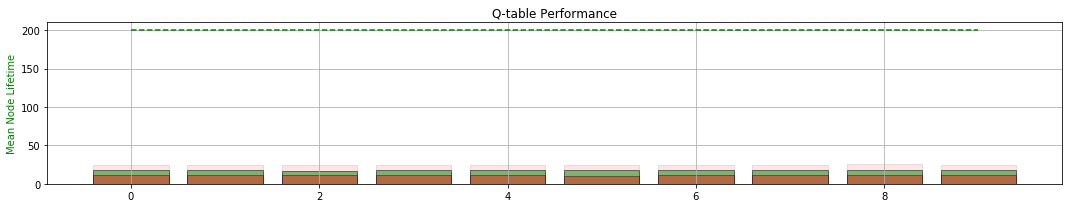

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  33996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  45.635
Validating... MEAN TIME:  54.715
Validating... MEAN TIME:  36.695
Validating... MEAN TIME:  57.265
Validating... MEAN TIME:  44.46
TRAINING TIME:0:00:25.739004


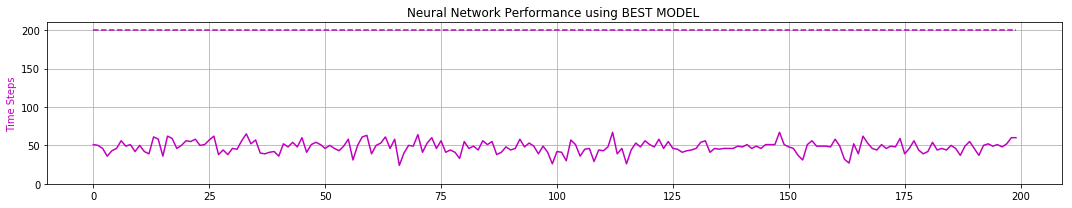

0 -max- [ 0.201  0.995  0.050  0.249  0.475]
0 -min- [-0.050 -0.550 -0.209 -1.497  0.425]

peak memory: 12566.82 MiB, increment: 10199.40 MiB
1 -max- [ 0.200  1.025  0.050  0.323  0.525]
1 -min- [-0.050 -0.410 -0.209 -1.534  0.476]

peak memory: 12535.91 MiB, increment: 10168.50 MiB
2 -max- [ 0.215  1.016  0.050  0.297  0.575]
2 -min- [-0.050 -0.406 -0.209 -1.452  0.525]

peak memory: 12532.83 MiB, increment: 10165.17 MiB
3 -max- [ 0.190  1.013  0.049  0.311  0.625]
3 -min- [-0.050 -0.410 -0.209 -1.475  0.575]

peak memory: 12558.39 MiB, increment: 10190.73 MiB
4 -max- [ 0.210  1.016  0.072  0.585  0.675]
4 -min- [-0.057 -0.580 -0.209 -1.486  0.625]

peak memory: 12564.28 MiB, increment: 10196.63 MiB
5 -max- [ 0.218  0.932  0.049  0.340  0.725]
5 -min- [-0.048 -0.603 -0.209 -1.585  0.675]

peak memory: 12564.17 MiB, increment: 10196.52 MiB
6 -max- [ 0.195  1.013  0.050  0.334  0.775]
6 -min- [-0.051 -0.413 -0.209 -1.553  0.725]

peak memory: 12564.20 MiB, increment: 10196.55 MiB
7 -max

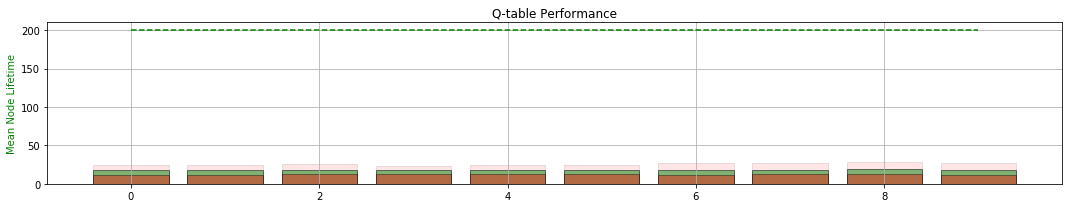

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  35996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  35.505
Validating... MEAN TIME:  34.03
Validating... MEAN TIME:  48.275
Validating... MEAN TIME:  58.97
Validating... MEAN TIME:  41.96
TRAINING TIME:0:00:24.039594


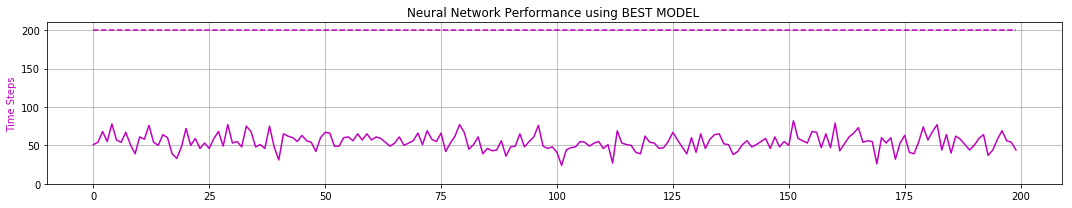

0 -max- [ 0.200  0.952  0.050  0.126  0.475]
0 -min- [-0.050 -0.410 -0.209 -1.475  0.425]

peak memory: 12712.86 MiB, increment: 10345.07 MiB
1 -max- [ 0.215  1.018  0.050  0.343  0.525]
1 -min- [-0.050 -0.409 -0.209 -1.515  0.475]

peak memory: 12637.46 MiB, increment: 10270.18 MiB
2 -max- [ 0.189  1.001  0.054  0.319  0.575]
2 -min- [-0.050 -0.407 -0.209 -1.489  0.525]

peak memory: 12738.62 MiB, increment: 10371.35 MiB
3 -max- [ 0.205  1.020  0.050  0.324  0.625]
3 -min- [-0.050 -0.413 -0.209 -1.490  0.575]

peak memory: 12563.72 MiB, increment: 10196.46 MiB
4 -max- [ 0.217  1.015  0.049  0.173  0.675]
4 -min- [-0.048 -0.576 -0.209 -1.526  0.626]

peak memory: 12524.98 MiB, increment: 10157.73 MiB
5 -max- [ 0.195  0.829  0.050  0.313  0.724]
5 -min- [-0.051 -0.417 -0.209 -1.329  0.675]

peak memory: 12563.93 MiB, increment: 10196.68 MiB
6 -max- [ 0.202  1.018  0.049  0.346  0.775]
6 -min- [-0.050 -0.543 -0.209 -1.661  0.725]

peak memory: 12550.83 MiB, increment: 10183.59 MiB
7 -max

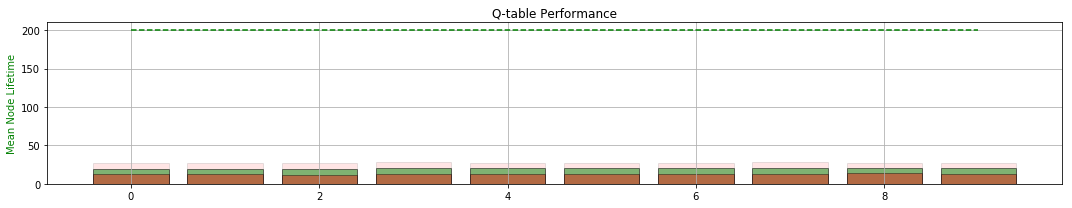

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  37996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  52.445
Validating... MEAN TIME:  63.205
Validating... MEAN TIME:  68.99
Validating... MEAN TIME:  100.325
Validating... MEAN TIME:  95.685
TRAINING TIME:0:00:33.758310


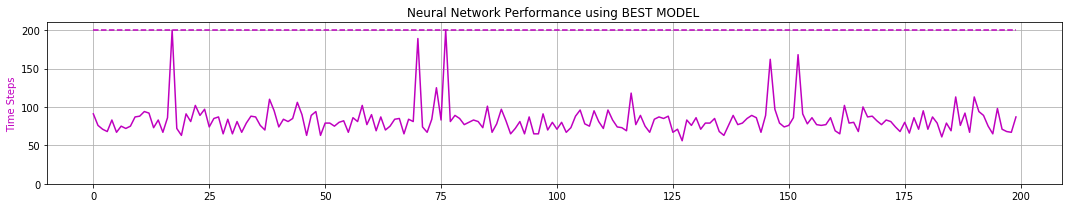

0 -max- [ 0.207  1.009  0.050  0.254  0.474]
0 -min- [-0.050 -0.406 -0.209 -1.495  0.425]

peak memory: 12550.72 MiB, increment: 10183.39 MiB
1 -max- [ 0.182  0.985  0.049  0.314  0.525]
1 -min- [-0.050 -0.524 -0.209 -1.470  0.475]

peak memory: 12749.17 MiB, increment: 10381.84 MiB
2 -max- [ 0.193  1.004  0.050  0.315  0.575]
2 -min- [-0.050 -0.586 -0.209 -1.440  0.525]

peak memory: 12564.00 MiB, increment: 10196.68 MiB
3 -max- [ 0.209  0.962  0.049  0.224  0.624]
3 -min- [-0.048 -0.600 -0.209 -1.473  0.575]

peak memory: 12711.05 MiB, increment: 10343.48 MiB
4 -max- [ 0.185  1.015  0.050  0.204  0.675]
4 -min- [-0.051 -0.586 -0.209 -1.461  0.625]

peak memory: 12720.62 MiB, increment: 10353.07 MiB
5 -max- [ 0.188  0.992  0.049  0.296  0.725]
5 -min- [-0.050 -0.588 -0.209 -1.480  0.675]

peak memory: 12564.24 MiB, increment: 10196.69 MiB
6 -max- [ 0.209  0.976  0.050  0.319  0.775]
6 -min- [-0.050 -0.595 -0.209 -1.463  0.725]

peak memory: 12563.92 MiB, increment: 10196.63 MiB
7 -max

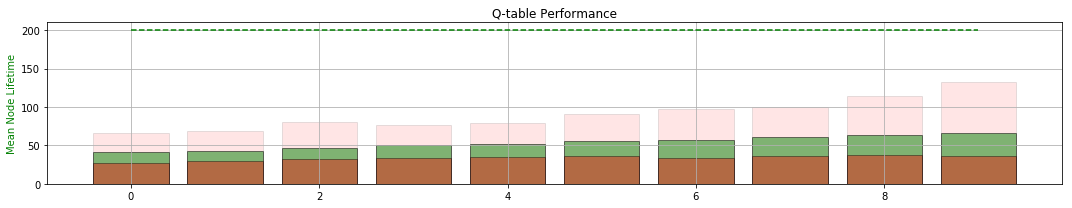

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  39996
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  118.2
Validating... MEAN TIME:  76.96
Validating... MEAN TIME:  80.75
Validating... MEAN TIME:  84.0
Validating... MEAN TIME:  106.815
TRAINING TIME:0:00:37.835861


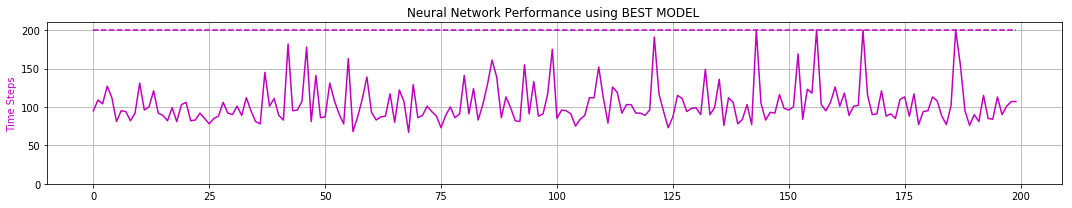

0 -max- [ 0.123  0.829  0.049  0.616  0.474]
0 -min- [-0.271 -1.302 -0.209 -1.203  0.425]

peak memory: 12566.73 MiB, increment: 10196.48 MiB
1 -max- [ 0.125  0.990  0.050  0.581  0.525]
1 -min- [-0.261 -1.243 -0.209 -1.383  0.475]

peak memory: 12629.25 MiB, increment: 10258.99 MiB
2 -max- [ 0.131  0.829  0.049  0.616  0.575]
2 -min- [-0.386 -1.443 -0.209 -1.191  0.525]

peak memory: 12566.81 MiB, increment: 10196.56 MiB
3 -max- [ 0.111  0.827  0.050  0.656  0.624]
3 -min- [-0.406 -1.498 -0.209 -1.191  0.575]

peak memory: 12566.83 MiB, increment: 10196.59 MiB
4 -max- [ 0.134  1.013  0.049  0.639  0.675]
4 -min- [-0.461 -1.648 -0.209 -1.476  0.625]

peak memory: 12544.98 MiB, increment: 10174.74 MiB
5 -max- [ 0.137  0.825  0.050  0.699  0.725]
5 -min- [-0.476 -1.642 -0.209 -1.138  0.675]

peak memory: 12558.54 MiB, increment: 10188.05 MiB
6 -max- [ 0.116  0.816  0.050  0.587  0.774]
6 -min- [-0.577 -1.694 -0.209 -1.167  0.725]

peak memory: 12750.15 MiB, increment: 10379.68 MiB
7 -max

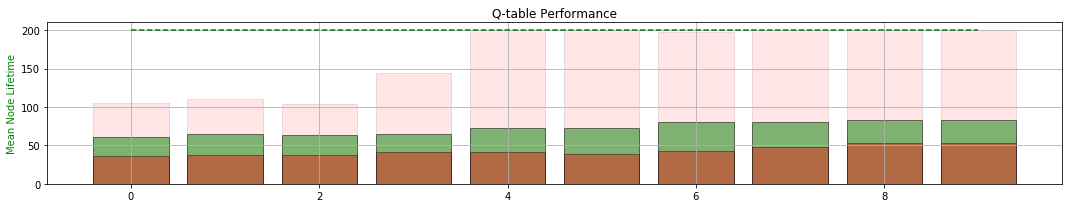

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  41985
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  114.83
Validating... MEAN TIME:  107.85
Validating... MEAN TIME:  103.92
Validating... MEAN TIME:  110.06
Validating... MEAN TIME:  125.555
TRAINING TIME:0:00:42.725406


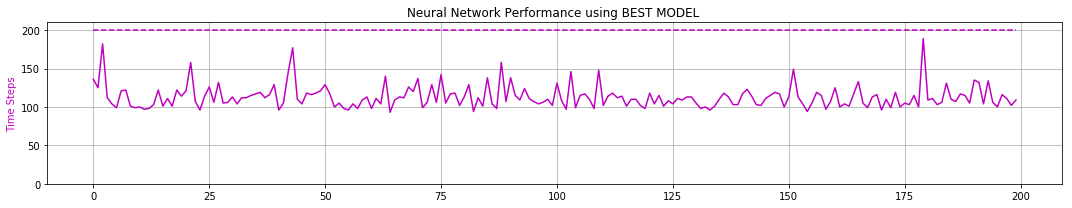

0 -max- [ 0.109  0.821  0.050  0.752  0.475]
0 -min- [-0.692 -1.865 -0.209 -1.158  0.426]

peak memory: 12568.41 MiB, increment: 10175.59 MiB
1 -max- [ 0.128  0.827  0.049  0.636  0.525]
1 -min- [-0.602 -1.698 -0.209 -1.166  0.475]

peak memory: 12586.62 MiB, increment: 10193.80 MiB
2 -max- [ 0.105  0.818  0.050  0.674  0.575]
2 -min- [-0.605 -1.686 -0.209 -1.117  0.525]

peak memory: 12589.45 MiB, increment: 10196.64 MiB
3 -max- [ 0.111  0.634  0.049  0.732  0.624]
3 -min- [-0.648 -1.702 -0.209 -1.126  0.575]

peak memory: 12755.33 MiB, increment: 10362.52 MiB
4 -max- [ 0.236  0.633  0.052  0.758  0.675]
4 -min- [-0.693 -1.843 -0.209 -0.937  0.625]

peak memory: 12721.40 MiB, increment: 10328.60 MiB
5 -max- [ 0.161  0.621  0.050  0.665  0.725]
5 -min- [-0.798 -1.886 -0.209 -1.088  0.675]

peak memory: 12582.72 MiB, increment: 10189.92 MiB
6 -max- [ 0.148  0.633  0.050  0.735  0.775]
6 -min- [-0.823 -1.884 -0.209 -1.199  0.726]

peak memory: 12541.04 MiB, increment: 10148.25 MiB
7 -max

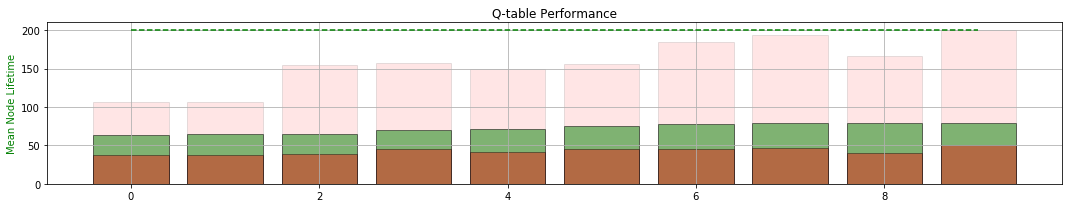

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  43983
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  135.515
Validating... MEAN TIME:  120.465
Validating... MEAN TIME:  110.95
Validating... MEAN TIME:  135.255
Validating... MEAN TIME:  157.57
TRAINING TIME:0:00:48.353853


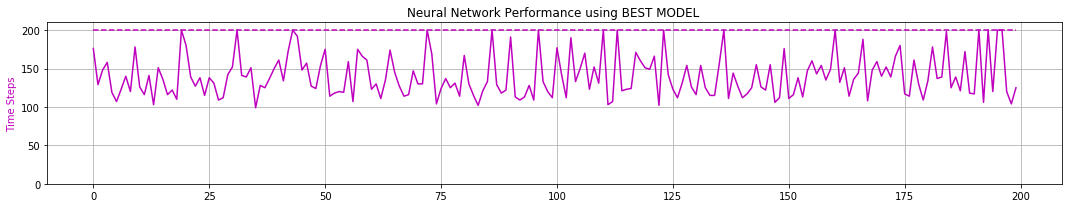

0 -max- [ 0.129  0.634  0.049  0.555  0.475]
0 -min- [-0.729 -1.847 -0.209 -0.972  0.426]

peak memory: 12608.73 MiB, increment: 10216.32 MiB
1 -max- [ 0.105  0.634  0.050  0.628  0.524]
1 -min- [-0.700 -1.791 -0.209 -0.945  0.475]

peak memory: 12589.03 MiB, increment: 10196.37 MiB
2 -max- [ 0.122  0.790  0.049  0.728  0.575]
2 -min- [-0.907 -2.055 -0.209 -1.171  0.525]

peak memory: 12561.01 MiB, increment: 10168.35 MiB
3 -max- [ 0.123  0.791  0.050  0.679  0.625]
3 -min- [-0.857 -1.992 -0.209 -1.128  0.575]

peak memory: 12723.06 MiB, increment: 10330.67 MiB
4 -max- [ 0.155  1.125  0.050  0.636  0.675]
4 -min- [-0.797 -1.882 -0.209 -1.676  0.625]

peak memory: 12589.26 MiB, increment: 10196.88 MiB
5 -max- [ 0.150  1.214  0.050  0.780  0.724]
5 -min- [-0.969 -2.008 -0.209 -1.728  0.676]

peak memory: 12581.34 MiB, increment: 10188.97 MiB
6 -max- [ 0.177  1.217  0.049  0.778  0.775]
6 -min- [-1.039 -2.205 -0.209 -1.687  0.725]

peak memory: 12768.42 MiB, increment: 10376.05 MiB
7 -max

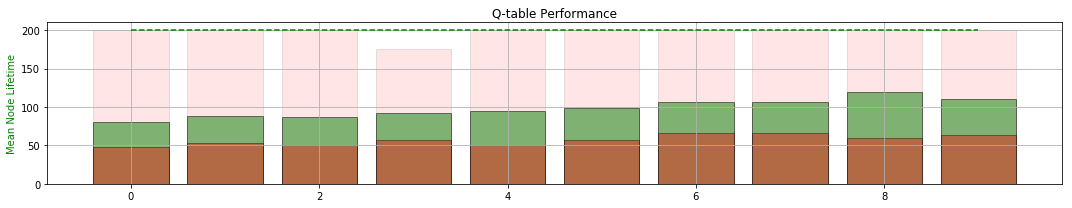

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  45923
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  153.29
Validating... MEAN TIME:  117.1
Validating... MEAN TIME:  136.6
Validating... MEAN TIME:  155.105
Validating... MEAN TIME:  123.595
TRAINING TIME:0:00:48.881171


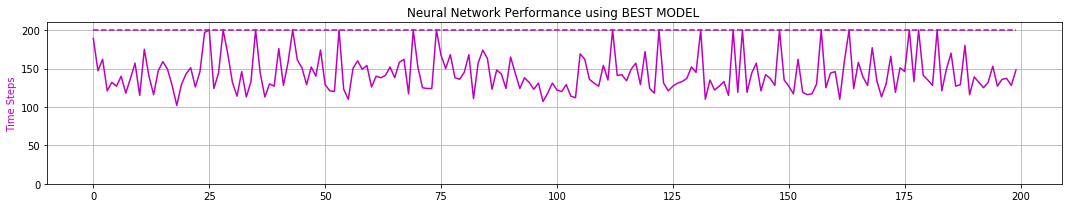

0 -max- [ 0.134  0.632  0.050  0.743  0.475]
0 -min- [-0.787 -1.791 -0.209 -0.933  0.426]

peak memory: 12768.59 MiB, increment: 10353.14 MiB
1 -max- [ 0.154  0.828  0.049  0.720  0.525]
1 -min- [-0.901 -1.878 -0.209 -1.179  0.475]

peak memory: 12771.79 MiB, increment: 10356.60 MiB
2 -max- [ 0.174  0.630  0.050  1.075  0.575]
2 -min- [-0.954 -2.008 -0.209 -1.178  0.525]

peak memory: 12575.78 MiB, increment: 10160.34 MiB
3 -max- [ 0.116  0.623  0.055  0.749  0.625]
3 -min- [-0.934 -1.970 -0.209 -1.124  0.575]

peak memory: 12612.32 MiB, increment: 10196.88 MiB
4 -max- [ 0.126  0.730  0.050  0.802  0.675]
4 -min- [-1.007 -1.996 -0.209 -1.155  0.625]

peak memory: 12612.09 MiB, increment: 10196.66 MiB
5 -max- [ 0.794  0.786  0.054  0.749  0.725]
5 -min- [-0.962 -1.882 -0.209 -1.058  0.675]

peak memory: 12556.98 MiB, increment: 10141.55 MiB
6 -max- [ 0.956  0.980  0.080  0.747  0.775]
6 -min- [-1.075 -2.067 -0.209 -1.013  0.725]

peak memory: 12583.27 MiB, increment: 10167.85 MiB
7 -max

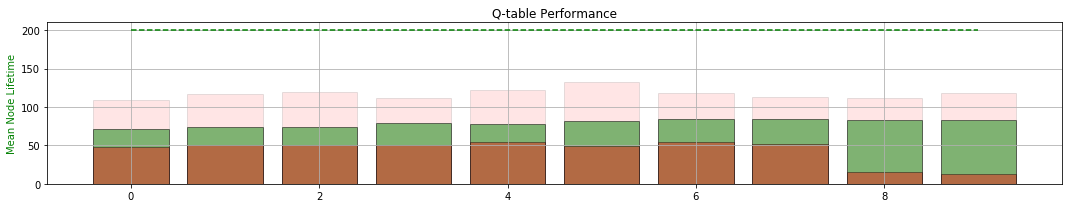

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  47923
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  122.71
Validating... MEAN TIME:  129.3
Validating... MEAN TIME:  120.06
Validating... MEAN TIME:  134.415
Validating... MEAN TIME:  129.73
TRAINING TIME:0:00:46.640079


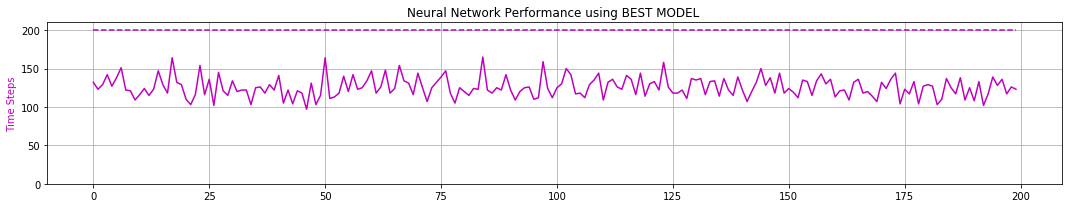

0 -max- [ 0.118  0.802  0.052  0.741  0.475]
0 -min- [-0.961 -1.977 -0.209 -1.223  0.425]

peak memory: 12612.20 MiB, increment: 10196.54 MiB
1 -max- [ 0.134  0.825  0.050  0.845  0.525]
1 -min- [-0.974 -2.056 -0.209 -1.161  0.476]

peak memory: 12612.14 MiB, increment: 10196.49 MiB
2 -max- [ 0.116  0.819  0.050  0.753  0.575]
2 -min- [-0.992 -2.026 -0.209 -1.202  0.525]

peak memory: 12594.27 MiB, increment: 10178.89 MiB
3 -max- [ 0.137  0.982  0.050  0.979  0.625]
3 -min- [-0.987 -1.983 -0.209 -1.470  0.575]

peak memory: 12755.27 MiB, increment: 10339.89 MiB
4 -max- [ 0.177  1.217  0.049  0.862  0.674]
4 -min- [-1.054 -2.040 -0.209 -1.735  0.626]

peak memory: 12566.68 MiB, increment: 10151.31 MiB
5 -max- [ 0.182  1.216  0.050  0.961  0.725]
5 -min- [-1.158 -2.226 -0.209 -1.742  0.675]

peak memory: 12596.83 MiB, increment: 10181.47 MiB
6 -max- [ 0.183  1.210  0.049  0.859  0.775]
6 -min- [-1.170 -2.163 -0.209 -1.743  0.725]

peak memory: 12672.54 MiB, increment: 10257.19 MiB
7 -max

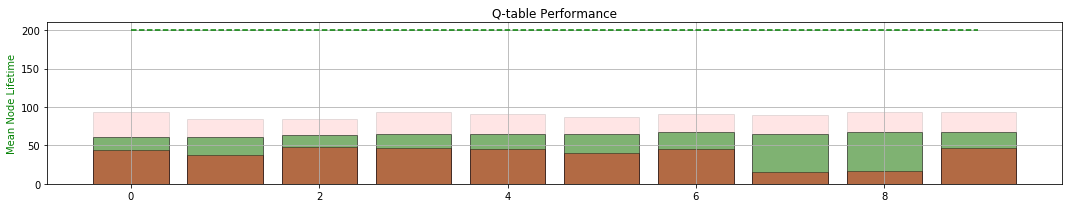

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  49923
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  113.92
Validating... MEAN TIME:  109.43
Validating... MEAN TIME:  100.815
Validating... MEAN TIME:  129.135
Validating... MEAN TIME:  124.735
TRAINING TIME:0:00:44.907000


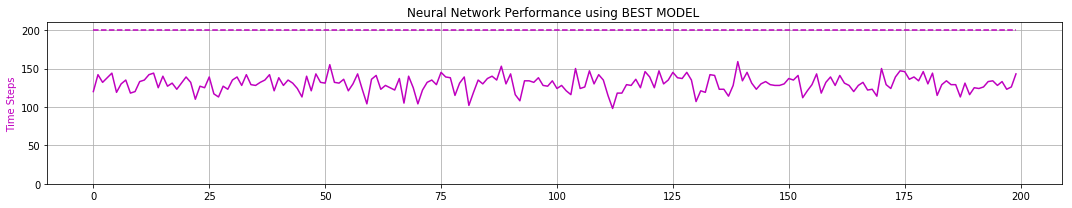

0 -max- [ 0.159  0.828  0.050  0.870  0.475]
0 -min- [-0.983 -2.173 -0.209 -1.235  0.425]

peak memory: 12611.77 MiB, increment: 10196.62 MiB
1 -max- [ 0.161  0.830  0.050  0.701  0.524]
1 -min- [-0.794 -1.828 -0.209 -1.244  0.475]

peak memory: 12741.57 MiB, increment: 10326.18 MiB
2 -max- [ 0.153  0.969  0.050  0.704  0.575]
2 -min- [-0.794 -1.826 -0.209 -1.508  0.525]

peak memory: 12586.43 MiB, increment: 10171.04 MiB
3 -max- [ 0.158  0.983  0.049  0.831  0.625]
3 -min- [-0.783 -1.821 -0.209 -1.446  0.576]

peak memory: 12560.26 MiB, increment: 10145.14 MiB
4 -max- [ 0.156  0.989  0.050  1.005  0.675]
4 -min- [-0.794 -1.820 -0.209 -1.482  0.625]

peak memory: 12759.50 MiB, increment: 10344.39 MiB
5 -max- [ 0.134  0.956  0.049  0.942  0.725]
5 -min- [-0.887 -1.865 -0.209 -1.466  0.675]

peak memory: 12604.54 MiB, increment: 10189.43 MiB
6 -max- [ 0.142  0.983  0.050  1.094  0.775]
6 -min- [-1.036 -1.980 -0.209 -1.509  0.725]

peak memory: 12645.85 MiB, increment: 10230.75 MiB
7 -max

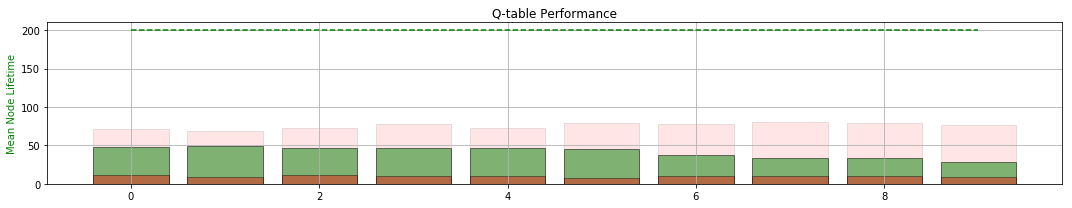

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  51923
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  155.845
Validating... MEAN TIME:  127.2
Validating... MEAN TIME:  104.905
Validating... MEAN TIME:  102.81
Validating... MEAN TIME:  102.35
TRAINING TIME:0:00:45.237337


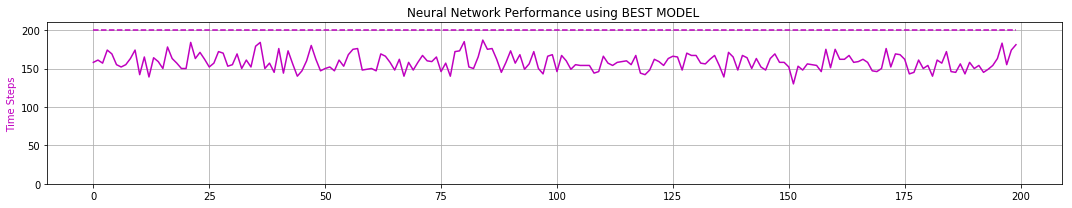

0 -max- [ 0.209  0.972  0.050  0.827  0.475]
0 -min- [-0.840 -2.034 -0.209 -1.505  0.425]

peak memory: 12575.59 MiB, increment: 10160.32 MiB
1 -max- [ 0.209  1.214  0.050  0.680  0.525]
1 -min- [-0.793 -1.878 -0.209 -1.694  0.475]

peak memory: 12766.47 MiB, increment: 10351.21 MiB
2 -max- [ 0.218  1.004  0.049  0.858  0.575]
2 -min- [-0.773 -1.886 -0.209 -1.573  0.525]

peak memory: 12565.08 MiB, increment: 10149.82 MiB
3 -max- [ 0.218  1.019  0.050  0.894  0.625]
3 -min- [-0.822 -1.895 -0.209 -1.536  0.575]

peak memory: 12581.21 MiB, increment: 10165.95 MiB
4 -max- [ 0.188  1.210  0.053  0.927  0.675]
4 -min- [-0.926 -2.027 -0.209 -1.700  0.625]

peak memory: 12611.91 MiB, increment: 10196.66 MiB
5 -max- [ 0.225  1.414  0.050  1.084  0.724]
5 -min- [-0.939 -2.049 -0.209 -2.238  0.676]

peak memory: 12596.61 MiB, increment: 10181.36 MiB
6 -max- [ 0.214  1.593  0.049  0.884  0.775]
6 -min- [-0.915 -2.034 -0.209 -2.344  0.726]

peak memory: 12611.37 MiB, increment: 10196.38 MiB
7 -max

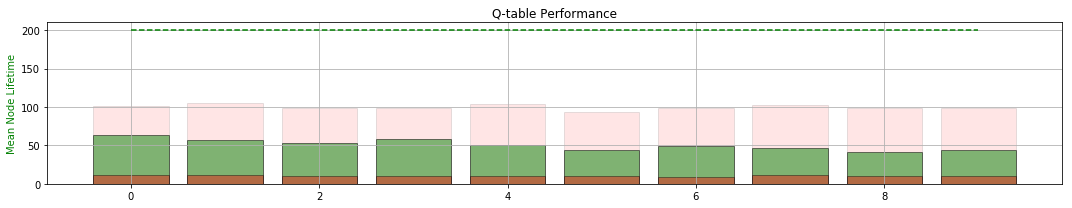

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  53923
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  110.785
Validating... MEAN TIME:  110.375
Validating... MEAN TIME:  119.235
Validating... MEAN TIME:  118.9
Validating... MEAN TIME:  108.665
TRAINING TIME:0:00:42.762487


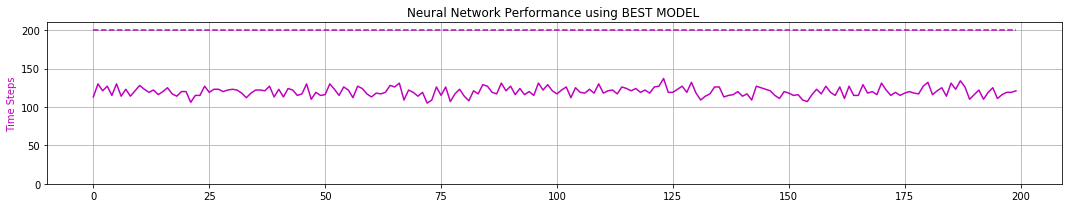

0 -max- [ 0.211  0.963  0.054  1.145  0.475]
0 -min- [-1.531 -2.236 -0.209 -1.602  0.425]

peak memory: 12534.07 MiB, increment: 10167.19 MiB
1 -max- [ 0.218  1.024  0.049  1.102  0.525]
1 -min- [-1.459 -2.240 -0.209 -1.574  0.475]

peak memory: 12551.25 MiB, increment: 10184.38 MiB
2 -max- [ 0.227  1.007  0.050  1.264  0.575]
2 -min- [-1.510 -2.166 -0.209 -1.632  0.526]

peak memory: 12519.64 MiB, increment: 10152.77 MiB
3 -max- [ 0.202  1.024  0.049  1.072  0.625]
3 -min- [-1.430 -2.175 -0.209 -1.628  0.575]

peak memory: 12520.73 MiB, increment: 10153.87 MiB
4 -max- [ 0.225  1.214  0.050  1.149  0.675]
4 -min- [-1.422 -2.164 -0.209 -1.742  0.625]

peak memory: 12536.91 MiB, increment: 10170.05 MiB
5 -max- [ 0.206  1.218  0.049  1.099  0.725]
5 -min- [-1.411 -2.174 -0.209 -1.748  0.676]

peak memory: 12651.17 MiB, increment: 10284.06 MiB
6 -max- [ 0.205  1.360  0.050  1.150  0.775]
6 -min- [-1.551 -2.237 -0.209 -1.964  0.725]

peak memory: 12563.59 MiB, increment: 10196.49 MiB
7 -max

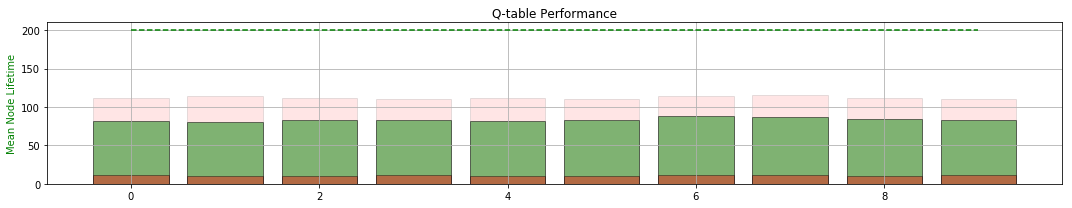

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  55923
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  104.915
Validating... MEAN TIME:  102.605
Validating... MEAN TIME:  158.065
Validating... MEAN TIME:  120.085
Validating... MEAN TIME:  134.67
TRAINING TIME:0:00:46.358915


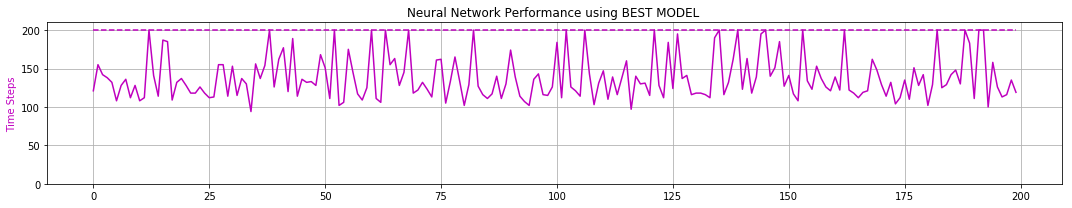

0 -max- [ 0.220  1.023  0.049  0.896  0.475]
0 -min- [-2.400 -3.154 -0.209 -1.505  0.425]

peak memory: 12587.77 MiB, increment: 10196.47 MiB
1 -max- [ 0.211  1.184  0.050  0.937  0.524]
1 -min- [-2.400 -3.157 -0.209 -1.717  0.475]

peak memory: 12578.02 MiB, increment: 10186.73 MiB
2 -max- [ 0.209  1.025  0.049  1.046  0.575]
2 -min- [-2.399 -3.148 -0.209 -1.578  0.525]

peak memory: 12584.44 MiB, increment: 10193.16 MiB
3 -max- [ 0.217  1.181  0.050  0.995  0.625]
3 -min- [-2.396 -3.139 -0.209 -1.786  0.576]

peak memory: 12576.29 MiB, increment: 10185.02 MiB
4 -max- [ 0.184  1.199  0.049  0.940  0.675]
4 -min- [-2.399 -3.276 -0.209 -1.705  0.625]

peak memory: 12560.98 MiB, increment: 10169.71 MiB
5 -max- [ 0.191  1.212  0.050  1.020  0.725]
5 -min- [-2.397 -3.154 -0.209 -1.748  0.675]

peak memory: 12540.71 MiB, increment: 10149.45 MiB
6 -max- [ 0.191  1.220  0.049  1.119  0.775]
6 -min- [-2.398 -3.154 -0.209 -1.746  0.725]

peak memory: 12662.60 MiB, increment: 10271.34 MiB
7 -max

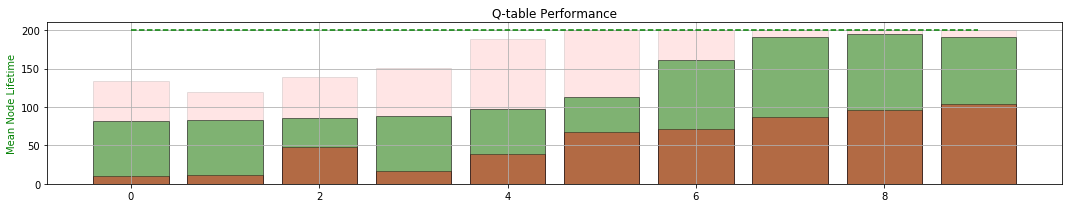

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  57377
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  198.945
Validating... MEAN TIME:  135.43
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  195.725
Validating... MEAN TIME:  191.625
TRAINING TIME:0:01:03.401656


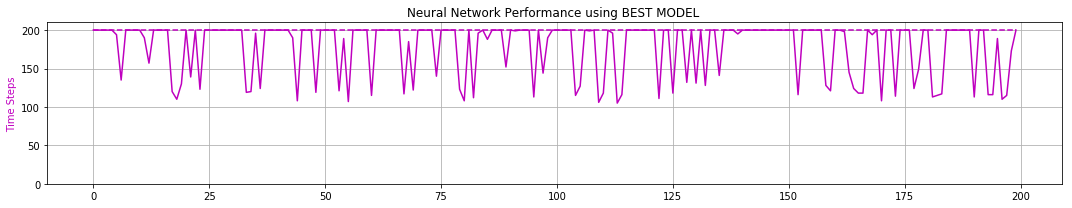

0 -max- [ 0.195  1.201  0.050  1.260  0.475]
0 -min- [-1.976 -2.745 -0.209 -1.759  0.426]

peak memory: 12822.78 MiB, increment: 10351.59 MiB
1 -max- [ 0.167  1.025  0.049  1.489  0.525]
1 -min- [-1.949 -2.745 -0.209 -1.712  0.475]

peak memory: 12846.51 MiB, increment: 10375.07 MiB
2 -max- [ 0.150  1.024  0.050  1.284  0.575]
2 -min- [-1.866 -2.723 -0.209 -1.657  0.525]

peak memory: 12826.02 MiB, increment: 10354.58 MiB
3 -max- [ 0.150  1.162  0.049  1.280  0.624]
3 -min- [-1.792 -2.601 -0.209 -1.922  0.575]

peak memory: 12752.08 MiB, increment: 10280.91 MiB
4 -max- [ 0.180  1.199  0.050  1.280  0.675]
4 -min- [-1.715 -2.546 -0.209 -1.682  0.626]

peak memory: 12634.45 MiB, increment: 10163.28 MiB
5 -max- [ 0.189  1.200  0.049  1.249  0.725]
5 -min- [-1.762 -2.578 -0.209 -1.729  0.675]

peak memory: 12709.16 MiB, increment: 10238.00 MiB
6 -max- [ 1.645  1.686  0.209  1.295  0.775]
6 -min- [-1.586 -2.425 -0.209 -1.659  0.725]

peak memory: 12656.18 MiB, increment: 10185.29 MiB
7 -max

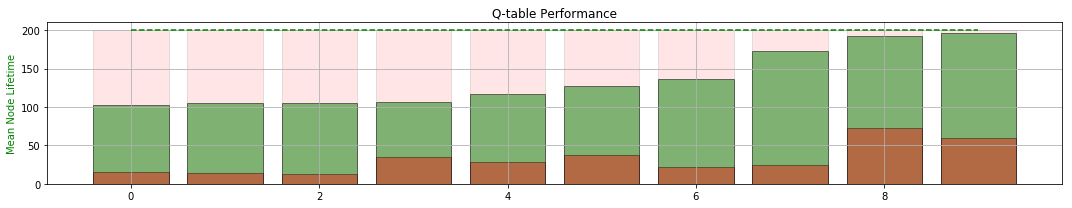

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  58846
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  193.68
Validating... MEAN TIME:  192.595
Validating... MEAN TIME:  136.29
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  181.415
TRAINING TIME:0:01:01.522609


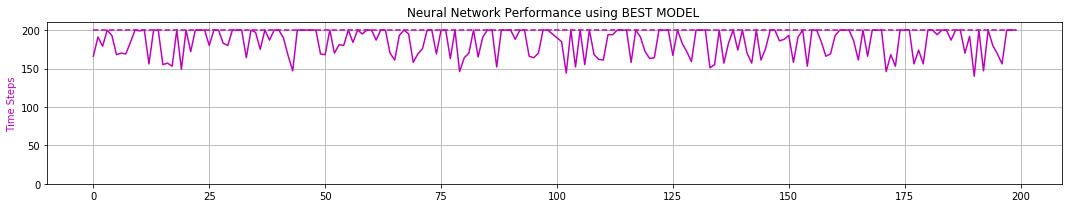

0 -max- [ 0.249  1.023  0.049  1.255  0.475]
0 -min- [-1.765 -2.578 -0.209 -1.644  0.425]

peak memory: 12615.93 MiB, increment: 10167.86 MiB
1 -max- [ 0.491  1.160  0.050  1.128  0.524]
1 -min- [-1.708 -2.547 -0.209 -1.869  0.475]

peak memory: 12678.79 MiB, increment: 10230.74 MiB
2 -max- [ 0.542  1.005  0.049  1.034  0.574]
2 -min- [-1.717 -2.541 -0.209 -1.731  0.525]

peak memory: 12649.23 MiB, increment: 10201.20 MiB
3 -max- [ 0.824  1.140  0.052  1.170  0.625]
3 -min- [-1.840 -2.715 -0.209 -1.902  0.575]

peak memory: 12642.08 MiB, increment: 10194.04 MiB
4 -max- [ 0.485  1.019  0.049  0.996  0.674]
4 -min- [-1.907 -2.742 -0.209 -1.932  0.625]

peak memory: 12626.95 MiB, increment: 10178.92 MiB
5 -max- [ 0.687  1.123  0.059  1.054  0.725]
5 -min- [-1.920 -2.753 -0.209 -1.712  0.675]

peak memory: 12637.71 MiB, increment: 10189.68 MiB
6 -max- [ 0.564  1.132  0.057  0.998  0.775]
6 -min- [-2.383 -3.151 -0.209 -1.731  0.725]

peak memory: 12643.99 MiB, increment: 10195.71 MiB
7 -max

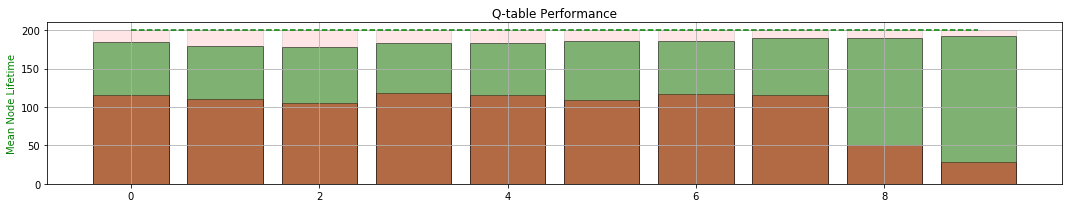

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  59726
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  194.295
Validating... MEAN TIME:  106.78
Validating... MEAN TIME:  95.675
Validating... MEAN TIME:  189.245
Validating... MEAN TIME:  131.535
TRAINING TIME:0:00:50.788767


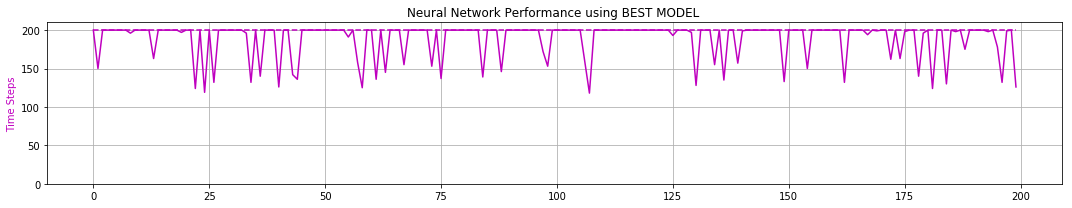

0 -max- [ 2.048  1.694  0.207  1.140  0.474]
0 -min- [-2.394 -3.152 -0.209 -1.343  0.426]

peak memory: 12701.76 MiB, increment: 10196.55 MiB
1 -max- [ 1.802  1.637  0.172  0.883  0.525]
1 -min- [-2.389 -3.155 -0.209 -1.326  0.475]

peak memory: 12701.73 MiB, increment: 10196.53 MiB
2 -max- [ 1.580  1.119  0.105  0.922  0.575]
2 -min- [-2.398 -3.140 -0.209 -1.347  0.525]

peak memory: 12666.34 MiB, increment: 10161.14 MiB
3 -max- [ 1.568  0.985  0.110  1.023  0.625]
3 -min- [-2.392 -3.087 -0.209 -0.965  0.575]

peak memory: 12701.72 MiB, increment: 10196.53 MiB
4 -max- [ 1.259  1.012  0.066  1.141  0.675]
4 -min- [-2.396 -3.133 -0.209 -1.376  0.625]

peak memory: 12655.41 MiB, increment: 10150.21 MiB
5 -max- [ 1.148  1.116  0.072  0.876  0.725]
5 -min- [-2.378 -3.076 -0.209 -1.274  0.676]

peak memory: 12729.88 MiB, increment: 10224.44 MiB
6 -max- [ 1.070  0.992  0.065  1.169  0.775]
6 -min- [-2.381 -2.972 -0.209 -1.355  0.725]

peak memory: 12797.89 MiB, increment: 10292.45 MiB
7 -max

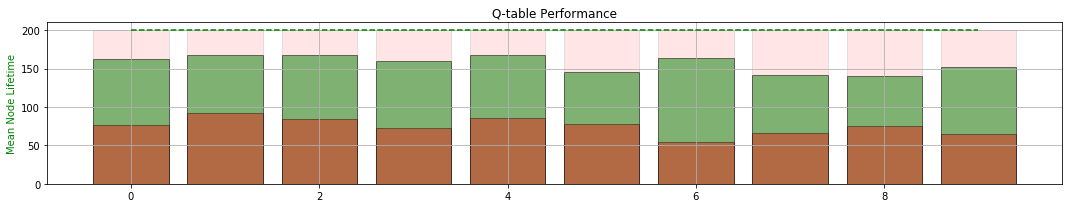

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  61330
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.935
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  191.415
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.99
TRAINING TIME:0:01:06.706922


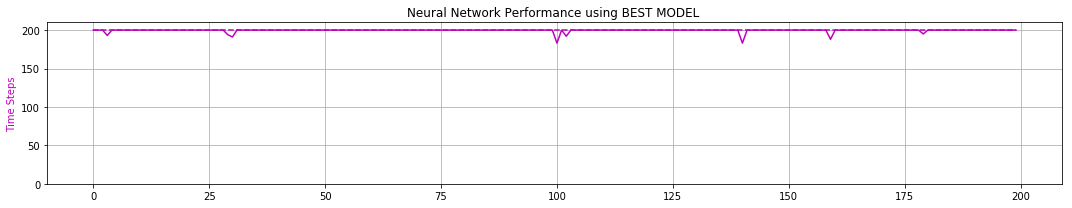

0 -max- [ 0.820  1.010  0.055  0.782  0.475]
0 -min- [-1.153 -2.001 -0.209 -1.259  0.425]

peak memory: 12669.06 MiB, increment: 10174.80 MiB
1 -max- [ 0.655  1.125  0.054  0.788  0.525]
1 -min- [-0.555 -1.077 -0.209 -1.294  0.475]

peak memory: 12724.48 MiB, increment: 10230.49 MiB
2 -max- [ 0.655  1.187  0.049  0.992  0.575]
2 -min- [-0.580 -1.069 -0.209 -1.431  0.526]

peak memory: 12643.79 MiB, increment: 10149.80 MiB
3 -max- [ 0.656  1.205  0.053  0.784  0.624]
3 -min- [-0.558 -1.134 -0.209 -1.507  0.576]

peak memory: 12637.57 MiB, increment: 10143.59 MiB
4 -max- [ 0.653  1.397  0.069  0.782  0.675]
4 -min- [-0.603 -1.049 -0.209 -1.738  0.626]

peak memory: 12867.30 MiB, increment: 10373.33 MiB
5 -max- [ 0.662  1.379  0.050  0.772  0.725]
5 -min- [-0.567 -1.128 -0.209 -1.742  0.675]

peak memory: 12637.20 MiB, increment: 10143.24 MiB
6 -max- [ 0.648  1.400  0.050  0.783  0.775]
6 -min- [-0.616 -1.074 -0.209 -1.802  0.726]

peak memory: 12648.98 MiB, increment: 10154.77 MiB
7 -max

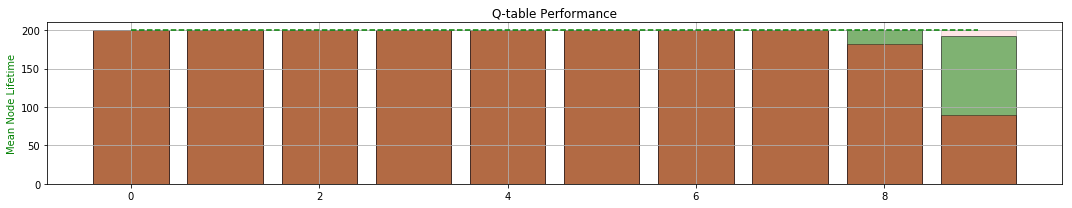

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  61365
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.675
Validating... MEAN TIME:  199.925
Validating... MEAN TIME:  199.615
Validating... MEAN TIME:  177.2
Validating... MEAN TIME:  200.0
TRAINING TIME:0:01:05.277838


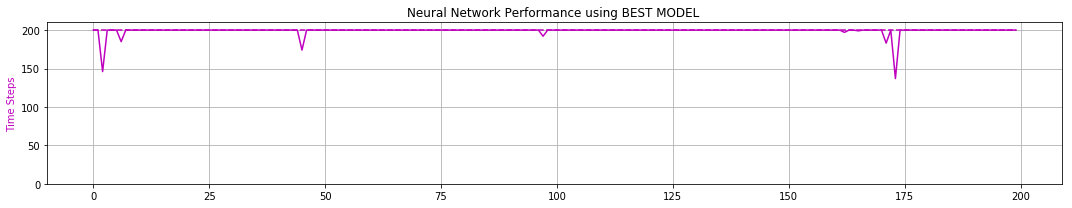

0 -max- [ 0.178  0.830  0.050  1.207  0.474]
0 -min- [-1.302 -1.104 -0.135 -1.350  0.425]

peak memory: 12661.66 MiB, increment: 10196.46 MiB
1 -max- [ 0.150  0.640  0.049  1.036  0.524]
1 -min- [-1.151 -0.791 -0.078 -0.990  0.475]

peak memory: 12661.66 MiB, increment: 10196.46 MiB
2 -max- [ 0.147  0.638  0.050  0.880  0.575]
2 -min- [-1.140 -0.805 -0.077 -0.992  0.526]

peak memory: 12781.36 MiB, increment: 10316.18 MiB
3 -max- [ 0.199  0.822  0.061  1.212  0.624]
3 -min- [-1.109 -1.113 -0.130 -1.364  0.575]

peak memory: 12664.02 MiB, increment: 10198.84 MiB
4 -max- [ 0.144  0.442  0.060  1.028  0.675]
4 -min- [-0.789 -0.921 -0.050 -0.793  0.625]

peak memory: 12653.68 MiB, increment: 10188.50 MiB
5 -max- [ 0.175  0.549  0.059  0.787  0.725]
5 -min- [-0.811 -0.742 -0.082 -0.761  0.675]

peak memory: 12781.10 MiB, increment: 10315.93 MiB
6 -max- [ 0.188  0.587  0.050  0.887  0.775]
6 -min- [-0.626 -0.738 -0.065 -0.868  0.726]

peak memory: 12634.20 MiB, increment: 10169.05 MiB
7 -max

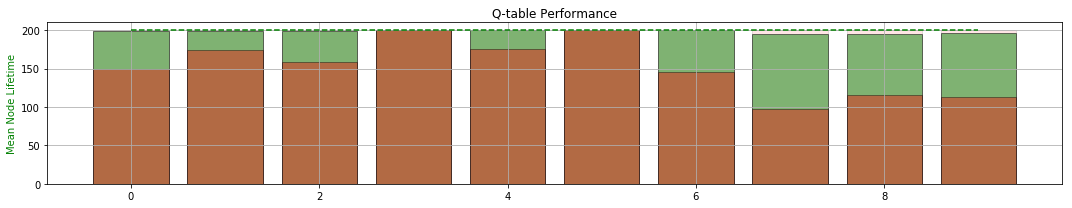

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  61474
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.715
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.86
Validating... MEAN TIME:  198.655
Validating... MEAN TIME:  200.0
TRAINING TIME:0:01:06.374884


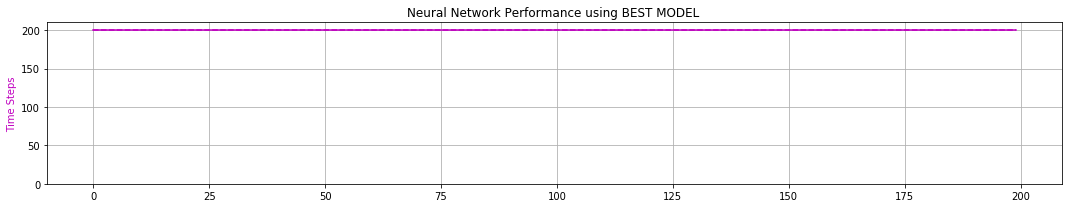

0 -max- [ 0.195  1.019  0.049  1.242  0.475]
0 -min- [-2.262 -2.248 -0.209 -1.508  0.425]

peak memory: 12847.27 MiB, increment: 10376.35 MiB
1 -max- [ 0.301  1.025  0.066  1.659  0.525]
1 -min- [-2.373 -2.221 -0.209 -1.623  0.475]

peak memory: 12636.85 MiB, increment: 10165.68 MiB
2 -max- [ 0.247  1.021  0.057  1.295  0.575]
2 -min- [-2.186 -2.065 -0.209 -1.508  0.526]

peak memory: 12739.53 MiB, increment: 10268.37 MiB
3 -max- [ 0.209  1.010  0.059  1.290  0.625]
3 -min- [-1.992 -1.507 -0.191 -1.661  0.575]

peak memory: 12850.45 MiB, increment: 10379.30 MiB
4 -max- [ 0.464  1.193  0.099  1.747  0.675]
4 -min- [-1.573 -1.513 -0.197 -1.660  0.625]

peak memory: 12756.13 MiB, increment: 10284.98 MiB
5 -max- [ 0.412  1.025  0.066  1.520  0.725]
5 -min- [-1.514 -1.331 -0.189 -1.540  0.676]

peak memory: 12667.82 MiB, increment: 10196.68 MiB
6 -max- [ 0.496  1.323  0.084  2.088  0.775]
6 -min- [-1.803 -2.126 -0.209 -1.730  0.725]

peak memory: 12667.74 MiB, increment: 10196.61 MiB
7 -max

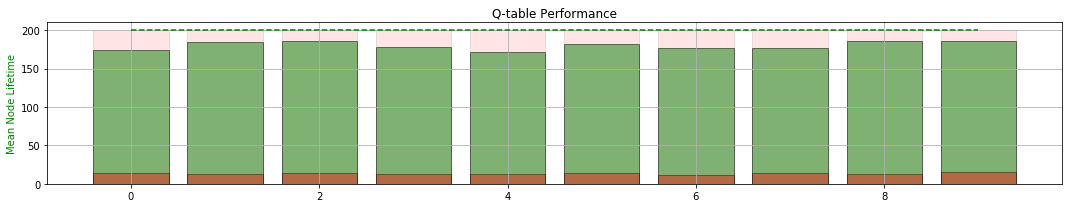

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  61732
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  190.6
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.98
TRAINING TIME:0:01:07.185308


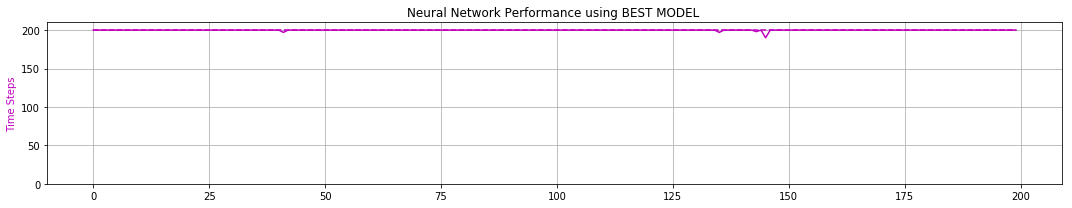

0 -max- [ 0.222  1.207  0.055  1.682  0.475]
0 -min- [-2.387 -1.738 -0.209 -1.698  0.426]

peak memory: 12649.75 MiB, increment: 10152.35 MiB
1 -max- [ 0.235  1.023  0.061  1.811  0.524]
1 -min- [-2.382 -1.717 -0.208 -1.575  0.475]

peak memory: 12642.36 MiB, increment: 10144.97 MiB
2 -max- [ 0.215  1.194  0.075  1.539  0.575]
2 -min- [-2.361 -1.521 -0.209 -1.704  0.525]

peak memory: 12693.75 MiB, increment: 10196.62 MiB
3 -max- [ 0.222  1.193  0.055  1.638  0.625]
3 -min- [-2.399 -1.706 -0.209 -1.799  0.575]

peak memory: 12702.68 MiB, increment: 10205.30 MiB
4 -max- [ 0.219  1.201  0.053  1.686  0.675]
4 -min- [-2.399 -1.664 -0.209 -1.692  0.625]

peak memory: 12735.13 MiB, increment: 10237.75 MiB
5 -max- [ 0.222  1.216  0.055  1.553  0.725]
5 -min- [-2.384 -1.571 -0.209 -1.741  0.675]

peak memory: 12840.60 MiB, increment: 10343.49 MiB
6 -max- [ 0.238  1.202  0.068  1.571  0.775]
6 -min- [-2.316 -1.571 -0.209 -1.816  0.725]

peak memory: 12871.84 MiB, increment: 10374.74 MiB
7 -max

In [19]:
while iteration < MAX_NO_OF_ITERATIONS:
    if iteration < 3:
        node_EPSILON   = (iteration+1) * 0.2
    else:
        node_EPSILON   = T_EPSILON
    
    print("\n")
    print("ITERATION #", iteration)
    print("MEAN TABULAR EPSILON = ", node_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        print("Problem SOLVED in iteration#", iteration)
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
    bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


    dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
    dqn.good_memory_counter += good_mem.shape[0]

    dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
    dqn.bad_memory_counter += bad_mem.shape[0]

    dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
    dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS

    print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
    print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    start = timeit.default_timer()
    for node_id in range(NO_OF_NODES):
        
        # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
        ###############################################
        [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
         C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
        ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
        # Mean values of pole length deviate from original value
        scaling_factor = 0.8 + (1.8 - 0.8) * (node_id + 1)/(NO_OF_NODES)
        ORIGNAL_LENGTH = 0.5    
        length_mean    = ORIGNAL_LENGTH * scaling_factor

        LENGTH_MAX = length_mean + 0.025
        LENGTH_MIN = length_mean - 0.025
        
        node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
                                    C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
        # CREATE STATE COMBINATIONS
        ###############################################

        node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN ],
                                            [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX ],
                                            [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
        ###############################################

        # GET Q-VALUES 
        %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

        # SAVE QFILE
        node_QFILE = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
        np.save(node_QFILE, node_q_table)
        #############################################################################################################################################
    stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()
    

In [20]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  4340.0
Total Serial Timesteps   :  5489839.0
Speed-up                 :  1264.94


In [21]:
pool.close()
pool.join()